The following two parts of the code are used for package installation and linking to cloud storage.

In [17]:
!pip install category_encoders
!pip install catboost
!pip install pytorch-tabnet
!pip install Levenshtein
!pip install lcensemble
!pip install seaborn
!pip install openpyxl
!pip install ignite
!pip install matplotlib
!pip install monai==1.3.0
!pip install nibabel
!pip install numpy
!pip install pandas
!pip install pynrrd
!pip install pytorch_ignite
!pip install scikit_learn
!pip install scipy
!pip install SimpleITK
!pip install scikit-image
!pip install typing_extensions
!pip install einops
print('load end')

load end


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



The following section of the code defines a set of parameters for the preprocessing process in the style of Monai's dynUnet. Its specific parameters are determined by the results of data exploration.

In [19]:
task_name = {

    "08": "Dataset247_monaiData",

}

patch_size = {

    "08": [224, 224, 32],

}

spacing = {

    "08": [0.78125, 0.78125, 2.4999999999999996],

}

clip_values = {

    "08": [-60, 260],

}

normalize_values = {

    "08": [100.78263092041016, 49.40095138549805],

}

data_loader_params = {

    "08": {"batch_size": 2},

}

deep_supr_num = {

    "08": 3,

}


The following code defines how to obtain our own model and the models provided by the MONAI framework.

In [20]:
import os
import torch
from monai.networks.nets import DynUNet
# from dynunet_check import DynUNet
# from task_params import deep_supr_num, patch_size, spacing


def get_kernels_strides(task_id):
    """
    This function is only used for decathlon datasets with the provided patch sizes.
    When refering this method for other tasks, please ensure that the patch size for each spatial dimension should
    be divisible by the product of all strides in the corresponding dimension.
    In addition, the minimal spatial size should have at least one dimension that has twice the size of
    the product of all strides. For patch sizes that cannot find suitable strides, an error will be raised.

    """
    sizes, spacings = patch_size[task_id], spacing[task_id]
    input_size = sizes
    strides, kernels = [], []
    while True:
        spacing_ratio = [sp / min(spacings) for sp in spacings]
        stride = [2 if ratio <= 2 and size >= 8 else 1 for (ratio, size) in zip(spacing_ratio, sizes)]
        kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
        if all(s == 1 for s in stride):
            break
        for idx, (i, j) in enumerate(zip(sizes, stride)):
            if i % j != 0:
                raise ValueError(
                    f"Patch size is not supported, please try to modify the size {input_size[idx]} in the spatial dimension {idx}."
                )
        sizes = [i / j for i, j in zip(sizes, stride)]
        spacings = [i * j for i, j in zip(spacings, stride)]
        kernels.append(kernel)
        strides.append(stride)

    strides.insert(0, len(spacings) * [1])
    kernels.append(len(spacings) * [3])
    return kernels, strides


def get_network(properties, task_id, pretrain_path, checkpoint=None):
    n_class = 5  # len(properties["labels"])
    in_channels = 1  # len(properties["modality"])
    kernels, strides = get_kernels_strides(task_id)

    # net = DynUNet(
    #     spatial_dims=3,
    #     in_channels=in_channels,
    #     out_channels=n_class,
    #     kernel_size=kernels,
    #     strides=strides,
    #     upsample_kernel_size=strides[1:],
    #     norm_name="instance",
    #     deep_supervision=True,
    #     deep_supr_num=deep_supr_num[task_id],
    # )
    # from net_swim import PlainConvUNet
    #
    # net = PlainConvUNet()
    # from network_mx import MedNeXt
    # net = MedNeXt(
    #     in_channels=1,
    #     n_channels=16,
    #     n_classes=5,
    #     exp_r=[2, 3, 4, 4, 4, 4, 4, 3, 2],  # Expansion ratio as in Swin Transformers
    #     # exp_r = 2,
    #     kernel_size=3,  # Can test kernel_size
    #     deep_supervision=True,  # Can be used to test deep supervision
    #     do_res=True,  # Can be used to individually test residual connection
    #     do_res_up_down=True,
    #     block_counts=[2, 2, 2, 2, 2, 2, 2, 2, 2],
    #     # block_counts = [3,4,8,8,8,8,8,4,3],
    #     checkpoint_style=None,
    #     dim='3d',
    #     grn=True,
    #     # expansion_type="cross"
    # )
    # from monai.networks.nets import SwinUNETR
    # net = SwinUNETR(img_size=(224, 224, 32), in_channels=1, out_channels=5, feature_size=24)
    # from monai.networks.nets import UNETR
    # print('run UNETR')
    # net = UNETR(
    #     in_channels=1,
    #     out_channels=5,  # 对于n个类别的分割任务，out_channels应该是n
    #     img_size=(224, 224, 32),
    #     feature_size=16,
    #     hidden_size=768,
    #     mlp_dim=3072,
    #     num_heads=12,
    #     pos_embed='perceptron',
    #     norm_name='instance',
    #     conv_block=True,
    #     res_block=True,
    #     dropout_rate=0.0
    # )

    # from Swin_NeXt import SwinNext
    print('run SwinNext cross')
    net = SwinNext(
        in_channels=1,
        n_channels=12,
        n_classes=5,
        exp_r=[2, 3, 4, 4, 4, 4, 4, 3, 2, 2],
        # exp_r = 2,
        kernel_size=3,
        deep_supervision=True,
        do_res=True,
        do_res_up_down=True,
        block_counts=[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        # block_counts = [3,4,8,8,8,8,8,4,3],
        checkpoint_style=None,
        dim='3d',
        grn=True,

        img_size=(224, 224, 32),
        expansion_type="cross"  # ["nochange", "add", "cat", "cross"]

    )

    # from MedNeXt_change import MedNeXt
    # print('MedNext')
    # net = MedNeXt(
    #     in_channels=1,
    #     n_channels=16,
    #     n_classes=5,
    #     exp_r=[2, 3, 4, 4, 4, 4, 4, 3, 2],  # Expansion ratio as in Swin Transformers
    #     # exp_r = 2,
    #     kernel_size=3,  # Can test kernel_size
    #     deep_supervision=True,  # Can be used to test deep supervision
    #     do_res=True,  # Can be used to individually test residual connection
    #     do_res_up_down=True,
    #     block_counts=[2, 2, 2, 2, 2, 2, 2, 2, 2],
    #     # block_counts = [3,4,8,8,8,8,8,4,3],
    #     checkpoint_style=None,
    #     dim='3d',
    #     grn=True,
    #     expansion_type="add", # ["nochange", "add", "cat", "cross"]
    #     trans_dim=30
    # )
    # ["nochange", "add", "cat", "cross"]
    # from swinUNETR import SwinUNETR
    # print('run SwinUnetR')
    # net = SwinUNETR(img_size=(224, 224, 32),
    #                 in_channels=1,
    #                 out_channels=5,
    #                 feature_size=24,
    #                 expansion_type="cat" )# ["nochange", "add", "cat", "cross"]

    if checkpoint is not None:
        pretrain_path = os.path.join(pretrain_path, checkpoint)
        print('load prepath:', pretrain_path)
        if os.path.exists(pretrain_path):
            net.load_state_dict(torch.load(pretrain_path))
            print("pretrained checkpoint: {} loaded".format(pretrain_path))
        else:
            print("no pretrained checkpoint")
    return net
if __name__ == '__main__':
    print('run model')

run model


The following code defines the steps required in the preprocessing process.

In [21]:
import numpy as np
from monai.transforms import (
    CastToTyped,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    LoadImaged,
    NormalizeIntensity,
    RandCropByPosNegLabeld,
    RandFlipd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandScaleIntensityd,
    RandZoomd,
    SpatialCrop,
    SpatialPadd,
    ToTensord,
    EnsureTyped,
)
from monai.transforms.compose import MapTransform
from monai.transforms.utils import generate_spatial_bounding_box
from skimage.transform import resize

# from task_params import clip_values, normalize_values, patch_size, spacing
from monai.utils import convert_to_tensor
from monai.data.utils import affine_to_spacing
import torch

def get_task_transforms(mode, task_id, pos_sample_num, neg_sample_num, num_samples):
    if mode != "test":
        keys = ["image", "label"]
    else:
        keys = ["image"]

    load_transforms = [
        LoadImaged(keys=keys, image_only=False),
        EnsureChannelFirstd(keys=keys),
    ]
    # 2. sampling
    sample_transforms = [
        PreprocessAnisotropic(
            keys=keys,
            clip_values=clip_values[task_id],
            pixdim=spacing[task_id],
            normalize_values=normalize_values[task_id],
            model_mode=mode,
        ),
        ToTensord(keys="image"),
    ]
    # 3. spatial transforms
    if mode == "train":
        other_transforms = [
            SpatialPadd(keys=["image", "label"], spatial_size=patch_size[task_id]),
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=patch_size[task_id],
                pos=pos_sample_num,
                neg=neg_sample_num,
                num_samples=num_samples,
                image_key="image",
                image_threshold=0,
            ),
            RandZoomd(
                keys=["image", "label"],
                min_zoom=0.9,
                max_zoom=1.2,
                mode=("trilinear", "nearest"),
                align_corners=(True, None),
                prob=0.15,
            ),
            RandGaussianNoised(keys=["image"], std=0.01, prob=0.15),
            RandGaussianSmoothd(
                keys=["image"],
                sigma_x=(0.5, 1.15),
                sigma_y=(0.5, 1.15),
                sigma_z=(0.5, 1.15),
                prob=0.15,
            ),
            RandScaleIntensityd(keys=["image"], factors=0.3, prob=0.15),
            RandFlipd(["image", "label"], spatial_axis=[0], prob=0.5),
            RandFlipd(["image", "label"], spatial_axis=[1], prob=0.5),
            RandFlipd(["image", "label"], spatial_axis=[2], prob=0.5),
            CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
            EnsureTyped(keys=["image", "label"]),
        ]
    elif mode == "validation":
        other_transforms = [
            CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
            EnsureTyped(keys=["image", "label"]),
        ]
    else:
        other_transforms = [
            CastToTyped(keys=["image"], dtype=(np.float32)),
            EnsureTyped(keys=["image"]),
        ]

    all_transforms = load_transforms + sample_transforms + other_transforms
    return Compose(all_transforms)


def resample_image(image, shape, anisotrophy_flag):
    resized_channels = []
    if anisotrophy_flag:
        for image_c in image:
            resized_slices = []
            for i in range(image_c.shape[-1]):
                image_c_2d_slice = image_c[:, :, i]
                image_c_2d_slice = resize(
                    image_c_2d_slice,
                    shape[:-1],
                    order=3,
                    mode="edge",
                    cval=0,
                    clip=True,
                    anti_aliasing=False,
                )
                resized_slices.append(image_c_2d_slice)
            resized = np.stack(resized_slices, axis=-1)
            resized = resize(
                resized,
                shape,
                order=0,
                mode="constant",
                cval=0,
                clip=True,
                anti_aliasing=False,
            )
            resized_channels.append(resized)
    else:
        for image_c in image:
            resized = resize(
                image_c,
                shape,
                order=3,
                mode="edge",
                cval=0,
                clip=True,
                anti_aliasing=False,
            )
            resized_channels.append(resized)
    resized = np.stack(resized_channels, axis=0)
    return resized


def resample_label(label, shape, anisotrophy_flag):
    reshaped = np.zeros(shape, dtype=np.uint8)
    n_class = np.max(label)
    if anisotrophy_flag:
        shape_2d = shape[:-1]
        depth = label.shape[-1]
        reshaped_2d = np.zeros((*shape_2d, depth), dtype=np.uint8)

        for class_ in range(1, int(n_class) + 1):
            for depth_ in range(depth):
                mask = label[0, :, :, depth_] == class_
                resized_2d = resize(
                    mask.astype(float),
                    shape_2d,
                    order=1,
                    mode="edge",
                    cval=0,
                    clip=True,
                    anti_aliasing=False,
                )
                reshaped_2d[:, :, depth_][resized_2d >= 0.5] = class_
        for class_ in range(1, int(n_class) + 1):
            mask = reshaped_2d == class_
            resized = resize(
                mask.astype(float),
                shape,
                order=0,
                mode="constant",
                cval=0,
                clip=True,
                anti_aliasing=False,
            )
            reshaped[resized >= 0.5] = class_
    else:
        for class_ in range(1, int(n_class) + 1):
            mask = label[0] == class_
            resized = resize(
                mask.astype(float),
                shape,
                order=1,
                mode="edge",
                cval=0,
                clip=True,
                anti_aliasing=False,
            )
            reshaped[resized >= 0.5] = class_

    reshaped = np.expand_dims(reshaped, 0)
    return reshaped


def recovery_prediction(prediction, shape, anisotrophy_flag):
    reshaped = np.zeros(shape, dtype=np.uint8)
    n_class = shape[0]
    if anisotrophy_flag:
        c, h, w = prediction.shape[:-1]
        d = shape[-1]
        reshaped_d = np.zeros((c, h, w, d), dtype=np.uint8)
        for class_ in range(1, n_class):
            mask = prediction[class_] == 1
            resized_d = resize(
                mask.astype(float),
                (h, w, d),
                order=0,
                mode="constant",
                cval=0,
                clip=True,
                anti_aliasing=False,
            )
            reshaped_d[class_][resized_d >= 0.5] = 1

        for class_ in range(1, n_class):
            for depth_ in range(d):
                mask = reshaped_d[class_, :, :, depth_] == 1
                resized_hw = resize(
                    mask.astype(float),
                    shape[1:-1],
                    order=1,
                    mode="edge",
                    cval=0,
                    clip=True,
                    anti_aliasing=False,
                )
                reshaped[class_, :, :, depth_][resized_hw >= 0.5] = 1
    else:
        for class_ in range(1, n_class):
            mask = prediction[class_] == 1
            resized = resize(
                mask.astype(float),
                shape[1:],
                order=1,
                mode="edge",
                cval=0,
                clip=True,
                anti_aliasing=False,
            )
            reshaped[class_][resized >= 0.5] = 1

    return reshaped


class PreprocessAnisotropic(MapTransform):
    """
    This transform class takes NNUNet's preprocessing method for reference.
    That code is in:
    https://github.com/MIC-DKFZ/nnUNet/blob/master/nnunet/preprocessing/preprocessing.py

    """

    def __init__(
        self,
        keys,
        clip_values,
        pixdim,
        normalize_values,
        model_mode,
    ) -> None:
        super().__init__(keys)
        self.keys = keys
        self.low = clip_values[0]
        self.high = clip_values[1]
        self.target_spacing = pixdim
        self.mean = normalize_values[0]
        self.std = normalize_values[1]
        self.training = False
        self.crop_foreg = CropForegroundd(keys=["image", "label"], source_key="image")
        self.normalize_intensity = NormalizeIntensity(nonzero=True, channel_wise=True)
        if model_mode in ["train"]:
            self.training = True

    def calculate_new_shape(self, spacing, shape):
        spacing_ratio = np.array(spacing) / np.array(self.target_spacing)
        new_shape = (spacing_ratio * np.array(shape)).astype(int).tolist()
        return new_shape

    def check_anisotrophy(self, spacing):
        def check(spacing):

            return np.max(spacing) / np.min(spacing) >= 3

        return check(spacing) or check(self.target_spacing)

    def __call__(self, data):
        # load data
        d = dict(data)
        image = d["image"]
        meta_dict = d["image"].meta
        # spacing_vals = convert_to_tensor(meta_dict['affine'], track_meta=False, wrap_sequence=True)
        spacing_vals = meta_dict['affine']
        if spacing_vals.ndim == 1:  # vector
            image_spacings = spacing_vals[:3][None]
        elif spacing_vals.ndim == 2:  # matrix
            image_spacings = affine_to_spacing(spacing_vals, 3)[None]
        else:
            raise ValueError("data[spacing_key] must be a vector or a matrix.")

        # image_spacings = d["image_meta_dict"]["pixdim"][1:4].tolist()
        # print(image_spacings)
        # image_spacings = [0.761719, 0.761719, 2.5]
        image_spacings = image_spacings.tolist()[0]
        if "label" in self.keys:
            label = d["label"]
            label[label < 0] = 0

        if self.training:
            # only task 04 does not be impacted
            cropped_data = self.crop_foreg({"image": image, "label": label})
            image, label = cropped_data["image"], cropped_data["label"]
        else:
            d["original_shape"] = np.array(image.shape[1:])
            box_start, box_end = generate_spatial_bounding_box(image)
            image = SpatialCrop(roi_start=box_start, roi_end=box_end)(image)
            d["bbox"] = np.vstack([box_start, box_end])
            d["crop_shape"] = np.array(image.shape[1:])

        original_shape = image.shape[1:]
        # calculate shape
        resample_flag = False
        anisotrophy_flag = False

        image = image.numpy()
        if self.target_spacing != image_spacings:
            # resample
            resample_flag = True
            resample_shape = self.calculate_new_shape(image_spacings, original_shape)
            anisotrophy_flag = self.check_anisotrophy(image_spacings)
            image = resample_image(image, resample_shape, anisotrophy_flag)
            if self.training:
                label = resample_label(label, resample_shape, anisotrophy_flag)

        d["resample_flag"] = resample_flag
        d["anisotrophy_flag"] = anisotrophy_flag
        # clip image for CT dataset
        if self.low != 0 or self.high != 0:
            image = np.clip(image, self.low, self.high)
            image = (image - self.mean) / self.std
        else:
            image = self.normalize_intensity(image.copy())

        # table_info_list = d['table']
        # new_matrix = np.zeros_like(image)[:,:,:,0] # 1, 512, 512, n
        # new_matrix = np.expand_dims(new_matrix, axis=-1)
        # for id_z, str_value in enumerate(table_info_list):
        #     if id_z == 0:
        #         continue
        #     feature_value = np.array(str_value)
        #     new_matrix[0,id_z - 1,0,0] = feature_value
        #
        # new_image = np.concatenate((image, new_matrix), axis=-1)
        new_image = image
        d["image"] = new_image

        if "label" in self.keys:
            d["label"] = label

        return d
if __name__ == "__main__":
    print('run transform')

run transform


The following code defines the sliding window inference process.

In [22]:
from __future__ import annotations

import itertools
from collections.abc import Callable, Mapping, Sequence
from typing import Any, Iterable

import numpy as np
import torch
import torch.nn.functional as F

from monai.data.meta_tensor import MetaTensor
from monai.data.utils import compute_importance_map, dense_patch_slices, get_valid_patch_size
from monai.utils import (
    BlendMode,
    PytorchPadMode,
    convert_data_type,
    convert_to_dst_type,
    ensure_tuple,
    ensure_tuple_rep,
    fall_back_tuple,
    look_up_option,
    optional_import,
    pytorch_after,
)

tqdm, _ = optional_import("tqdm", name="tqdm")
_nearest_mode = "nearest-exact" if pytorch_after(1, 11) else "nearest"

__all__ = ["sliding_window_inference"]


def sliding_window_inference(
    inputs: torch.Tensor | MetaTensor,
    roi_size: Sequence[int] | int,
    sw_batch_size: int,
    predictor: Callable[..., torch.Tensor | Sequence[torch.Tensor] | dict[Any, torch.Tensor]],
    overlap: Sequence[float] | float = 0.25,
    mode: BlendMode | str = BlendMode.CONSTANT,
    sigma_scale: Sequence[float] | float = 0.125,
    padding_mode: PytorchPadMode | str = PytorchPadMode.CONSTANT,
    cval: float = 0.0,
    sw_device: torch.device | str | None = None,
    device: torch.device | str | None = None,
    progress: bool = False,
    roi_weight_map: torch.Tensor | None = None,
    process_fn: Callable | None = None,
    buffer_steps: int | None = None,
    buffer_dim: int = -1,
    with_coord: bool = False,
    *args: Any,
    **kwargs: Any,
) -> torch.Tensor | tuple[torch.Tensor, ...] | dict[Any, torch.Tensor]:
    """
    Sliding window inference on `inputs` with `predictor`.

    The outputs of `predictor` could be a tensor, a tuple, or a dictionary of tensors.
    Each output in the tuple or dict value is allowed to have different resolutions with respect to the input.
    e.g., the input patch spatial size is [128,128,128], the output (a tuple of two patches) patch sizes
    could be ([128,64,256], [64,32,128]).
    In this case, the parameter `overlap` and `roi_size` need to be carefully chosen to ensure the output ROI is still
    an integer. If the predictor's input and output spatial sizes are not equal, we recommend choosing the parameters
    so that `overlap*roi_size*output_size/input_size` is an integer (for each spatial dimension).

    When roi_size is larger than the inputs' spatial size, the input image are padded during inference.
    To maintain the same spatial sizes, the output image will be cropped to the original input size.

    Args:
        inputs: input image to be processed (assuming NCHW[D])
        roi_size: the spatial window size for inferences.
            When its components have None or non-positives, the corresponding inputs dimension will be used.
            if the components of the `roi_size` are non-positive values, the transform will use the
            corresponding components of img size. For example, `roi_size=(32, -1)` will be adapted
            to `(32, 64)` if the second spatial dimension size of img is `64`.
        sw_batch_size: the batch size to run window slices.
        predictor: given input tensor ``patch_data`` in shape NCHW[D],
            The outputs of the function call ``predictor(patch_data)`` should be a tensor, a tuple, or a dictionary
            with Tensor values. Each output in the tuple or dict value should have the same batch_size, i.e. NM'H'W'[D'];
            where H'W'[D'] represents the output patch's spatial size, M is the number of output channels,
            N is `sw_batch_size`, e.g., the input shape is (7, 1, 128,128,128),
            the output could be a tuple of two tensors, with shapes: ((7, 5, 128, 64, 256), (7, 4, 64, 32, 128)).
            In this case, the parameter `overlap` and `roi_size` need to be carefully chosen
            to ensure the scaled output ROI sizes are still integers.
            If the `predictor`'s input and output spatial sizes are different,
            we recommend choosing the parameters so that ``overlap*roi_size*zoom_scale`` is an integer for each dimension.
        overlap: Amount of overlap between scans along each spatial dimension, defaults to ``0.25``.
        mode: {``"constant"``, ``"gaussian"``}
            How to blend output of overlapping windows. Defaults to ``"constant"``.

            - ``"constant``": gives equal weight to all predictions.
            - ``"gaussian``": gives less weight to predictions on edges of windows.

        sigma_scale: the standard deviation coefficient of the Gaussian window when `mode` is ``"gaussian"``.
            Default: 0.125. Actual window sigma is ``sigma_scale`` * ``dim_size``.
            When sigma_scale is a sequence of floats, the values denote sigma_scale at the corresponding
            spatial dimensions.
        padding_mode: {``"constant"``, ``"reflect"``, ``"replicate"``, ``"circular"``}
            Padding mode for ``inputs``, when ``roi_size`` is larger than inputs. Defaults to ``"constant"``
            See also: https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html
        cval: fill value for 'constant' padding mode. Default: 0
        sw_device: device for the window data.
            By default the device (and accordingly the memory) of the `inputs` is used.
            Normally `sw_device` should be consistent with the device where `predictor` is defined.
        device: device for the stitched output prediction.
            By default the device (and accordingly the memory) of the `inputs` is used. If for example
            set to device=torch.device('cpu') the gpu memory consumption is less and independent of the
            `inputs` and `roi_size`. Output is on the `device`.
        progress: whether to print a `tqdm` progress bar.
        roi_weight_map: pre-computed (non-negative) weight map for each ROI.
            If not given, and ``mode`` is not `constant`, this map will be computed on the fly.
        process_fn: process inference output and adjust the importance map per window
        buffer_steps: the number of sliding window iterations along the ``buffer_dim``
            to be buffered on ``sw_device`` before writing to ``device``.
            (Typically, ``sw_device`` is ``cuda`` and ``device`` is ``cpu``.)
            default is None, no buffering. For the buffer dim, when spatial size is divisible by buffer_steps*roi_size,
            (i.e. no overlapping among the buffers) non_blocking copy may be automatically enabled for efficiency.
        buffer_dim: the spatial dimension along which the buffers are created.
            0 indicates the first spatial dimension. Default is -1, the last spatial dimension.
        with_coord: whether to pass the window coordinates to ``predictor``. Default is False.
            If True, the signature of ``predictor`` should be ``predictor(patch_data, patch_coord, ...)``.
        args: optional args to be passed to ``predictor``.
        kwargs: optional keyword args to be passed to ``predictor``.

    Note:
        - input must be channel-first and have a batch dim, supports N-D sliding window.

    """
    table = inputs["table"]
    inputs = inputs["inputs"]
    buffered = buffer_steps is not None and buffer_steps > 0
    num_spatial_dims = len(inputs.shape) - 2
    if buffered:
        if buffer_dim < -num_spatial_dims or buffer_dim > num_spatial_dims:
            raise ValueError(f"buffer_dim must be in [{-num_spatial_dims}, {num_spatial_dims}], got {buffer_dim}.")
        if buffer_dim < 0:
            buffer_dim += num_spatial_dims
    overlap = ensure_tuple_rep(overlap, num_spatial_dims)
    for o in overlap:
        if o < 0 or o >= 1:
            raise ValueError(f"overlap must be >= 0 and < 1, got {overlap}.")
    compute_dtype = inputs.dtype

    # determine image spatial size and batch size
    # Note: all input images must have the same image size and batch size
    batch_size, _, *image_size_ = inputs.shape
    device = device or inputs.device
    sw_device = sw_device or inputs.device

    temp_meta = None
    if isinstance(inputs, MetaTensor):
        temp_meta = MetaTensor([]).copy_meta_from(inputs, copy_attr=False)
    inputs = convert_data_type(inputs, torch.Tensor, wrap_sequence=True)[0]
    roi_size = fall_back_tuple(roi_size, image_size_)

    # in case that image size is smaller than roi size
    image_size = tuple(max(image_size_[i], roi_size[i]) for i in range(num_spatial_dims))
    pad_size = []
    for k in range(len(inputs.shape) - 1, 1, -1):
        diff = max(roi_size[k - 2] - inputs.shape[k], 0)
        half = diff // 2
        pad_size.extend([half, diff - half])
    if any(pad_size):
        inputs = F.pad(inputs, pad=pad_size, mode=look_up_option(padding_mode, PytorchPadMode), value=cval)

    # Store all slices
    scan_interval = _get_scan_interval(image_size, roi_size, num_spatial_dims, overlap)
    slices = dense_patch_slices(image_size, roi_size, scan_interval, return_slice=not buffered)

    num_win = len(slices)  # number of windows per image
    total_slices = num_win * batch_size  # total number of windows
    windows_range: Iterable
    if not buffered:
        non_blocking = False
        windows_range = range(0, total_slices, sw_batch_size)
    else:
        slices, n_per_batch, b_slices, windows_range = _create_buffered_slices(
            slices, batch_size, sw_batch_size, buffer_dim, buffer_steps
        )
        non_blocking, _ss = torch.cuda.is_available(), -1
        for x in b_slices[:n_per_batch]:
            if x[1] < _ss:  # detect overlapping slices
                non_blocking = False
                break
            _ss = x[2]

    # Create window-level importance map
    valid_patch_size = get_valid_patch_size(image_size, roi_size)
    if valid_patch_size == roi_size and (roi_weight_map is not None):
        importance_map_ = roi_weight_map
    else:
        try:
            valid_p_size = ensure_tuple(valid_patch_size)
            importance_map_ = compute_importance_map(
                valid_p_size, mode=mode, sigma_scale=sigma_scale, device=sw_device, dtype=compute_dtype
            )
            if len(importance_map_.shape) == num_spatial_dims and not process_fn:
                importance_map_ = importance_map_[None, None]  # adds batch, channel dimensions
        except Exception as e:
            raise RuntimeError(
                f"patch size {valid_p_size}, mode={mode}, sigma_scale={sigma_scale}, device={device}\n"
                "Seems to be OOM. Please try smaller patch size or mode='constant' instead of mode='gaussian'."
            ) from e
    importance_map_ = convert_data_type(importance_map_, torch.Tensor, device=sw_device, dtype=compute_dtype)[0]

    # stores output and count map
    output_image_list, count_map_list, sw_device_buffer, b_s, b_i = [], [], [], 0, 0  # type: ignore
    # for each patch
    for slice_g in tqdm(windows_range) if progress else windows_range:
        slice_range = range(slice_g, min(slice_g + sw_batch_size, b_slices[b_s][0] if buffered else total_slices))
        unravel_slice = [
            [slice(idx // num_win, idx // num_win + 1), slice(None)] + list(slices[idx % num_win])
            for idx in slice_range
        ]
        if sw_batch_size > 1:
            win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
        else:
            win_data = inputs[unravel_slice[0]].to(sw_device)
        if with_coord:
            temp = {"inputs":win_data, "table":table}
            seg_prob_out = predictor(temp, unravel_slice, *args, **kwargs)  # batched patch
        else:
            temp = {"inputs":win_data, "table":table}
            seg_prob_out = predictor(temp, *args, **kwargs)  # batched patch


        # convert seg_prob_out to tuple seg_tuple, this does not allocate new memory.
        dict_keys, seg_tuple = _flatten_struct(seg_prob_out)
        if process_fn:
            seg_tuple, w_t = process_fn(seg_tuple, win_data, importance_map_)
        else:
            w_t = importance_map_
        if len(w_t.shape) == num_spatial_dims:
            w_t = w_t[None, None]
        w_t = w_t.to(dtype=compute_dtype, device=sw_device)
        if buffered:
            c_start, c_end = b_slices[b_s][1:]
            if not sw_device_buffer:
                k = seg_tuple[0].shape[1]  # len(seg_tuple) > 1 is currently ignored
                sp_size = list(image_size)
                sp_size[buffer_dim] = c_end - c_start
                sw_device_buffer = [torch.zeros(size=[1, k, *sp_size], dtype=compute_dtype, device=sw_device)]
            for p, s in zip(seg_tuple[0], unravel_slice):
                offset = s[buffer_dim + 2].start - c_start
                s[buffer_dim + 2] = slice(offset, offset + roi_size[buffer_dim])
                s[0] = slice(0, 1)
                sw_device_buffer[0][s] += p * w_t
            b_i += len(unravel_slice)
            if b_i < b_slices[b_s][0]:
                continue
        else:
            sw_device_buffer = list(seg_tuple)

        for ss in range(len(sw_device_buffer)):
            b_shape = sw_device_buffer[ss].shape
            seg_chns, seg_shape = b_shape[1], b_shape[2:]
            z_scale = None
            if not buffered and seg_shape != roi_size:
                z_scale = [out_w_i / float(in_w_i) for out_w_i, in_w_i in zip(seg_shape, roi_size)]
                w_t = F.interpolate(w_t, seg_shape, mode=_nearest_mode)
            if len(output_image_list) <= ss:
                output_shape = [batch_size, seg_chns]
                output_shape += [int(_i * _z) for _i, _z in zip(image_size, z_scale)] if z_scale else list(image_size)
                # allocate memory to store the full output and the count for overlapping parts
                new_tensor: Callable = torch.empty if non_blocking else torch.zeros  # type: ignore
                output_image_list.append(new_tensor(output_shape, dtype=compute_dtype, device=device))
                count_map_list.append(torch.zeros([1, 1] + output_shape[2:], dtype=compute_dtype, device=device))
                w_t_ = w_t.to(device)
                for __s in slices:
                    if z_scale is not None:
                        __s = tuple(slice(int(_si.start * z_s), int(_si.stop * z_s)) for _si, z_s in zip(__s, z_scale))
                    count_map_list[-1][(slice(None), slice(None), *__s)] += w_t_
            if buffered:
                o_slice = [slice(None)] * len(inputs.shape)
                o_slice[buffer_dim + 2] = slice(c_start, c_end)
                img_b = b_s // n_per_batch  # image batch index
                o_slice[0] = slice(img_b, img_b + 1)
                if non_blocking:
                    output_image_list[0][o_slice].copy_(sw_device_buffer[0], non_blocking=non_blocking)
                else:
                    output_image_list[0][o_slice] += sw_device_buffer[0].to(device=device)
            else:
                sw_device_buffer[ss] *= w_t
                sw_device_buffer[ss] = sw_device_buffer[ss].to(device)
                _compute_coords(unravel_slice, z_scale, output_image_list[ss], sw_device_buffer[ss])
        sw_device_buffer = []
        if buffered:
            b_s += 1

    if non_blocking:
        torch.cuda.current_stream().synchronize()

    # account for any overlapping sections
    for ss in range(len(output_image_list)):
        output_image_list[ss] /= count_map_list.pop(0)

    # remove padding if image_size smaller than roi_size
    if any(pad_size):
        for ss, output_i in enumerate(output_image_list):
            zoom_scale = [_shape_d / _roi_size_d for _shape_d, _roi_size_d in zip(output_i.shape[2:], roi_size)]
            final_slicing: list[slice] = []
            for sp in range(num_spatial_dims):
                si = num_spatial_dims - sp - 1
                slice_dim = slice(
                    int(round(pad_size[sp * 2] * zoom_scale[si])),
                    int(round((pad_size[sp * 2] + image_size_[si]) * zoom_scale[si])),
                )
                final_slicing.insert(0, slice_dim)
            output_image_list[ss] = output_i[(slice(None), slice(None), *final_slicing)]

    final_output = _pack_struct(output_image_list, dict_keys)
    if temp_meta is not None:
        final_output = convert_to_dst_type(final_output, temp_meta, device=device)[0]
    else:
        final_output = convert_to_dst_type(final_output, inputs, device=device)[0]

    return final_output  # type: ignore


def _create_buffered_slices(slices, batch_size, sw_batch_size, buffer_dim, buffer_steps):
    """rearrange slices for buffering"""
    slices_np = np.asarray(slices)
    slices_np = slices_np[np.argsort(slices_np[:, buffer_dim, 0], kind="mergesort")]
    slices = [tuple(slice(c[0], c[1]) for c in i) for i in slices_np]
    slices_np = slices_np[:, buffer_dim]

    _, _, _b_lens = np.unique(slices_np[:, 0], return_counts=True, return_index=True)
    b_ends = np.cumsum(_b_lens).tolist()  # possible buffer flush boundaries
    x = [0, *b_ends][:: min(len(b_ends), int(buffer_steps))]
    if x[-1] < b_ends[-1]:
        x.append(b_ends[-1])
    n_per_batch = len(x) - 1
    windows_range = [
        range(b * x[-1] + x[i], b * x[-1] + x[i + 1], sw_batch_size)
        for b in range(batch_size)
        for i in range(n_per_batch)
    ]
    b_slices = []
    for _s, _r in enumerate(windows_range):
        s_s = slices_np[windows_range[_s - 1].stop % len(slices) if _s > 0 else 0, 0]
        s_e = slices_np[(_r.stop - 1) % len(slices), 1]
        b_slices.append((_r.stop, s_s, s_e))  # buffer index, slice start, slice end
    windows_range = itertools.chain(*windows_range)  # type: ignore
    return slices, n_per_batch, b_slices, windows_range


def _compute_coords(coords, z_scale, out, patch):
    """sliding window batch spatial scaling indexing for multi-resolution outputs."""
    for original_idx, p in zip(coords, patch):
        idx_zm = list(original_idx)  # 4D for 2D image, 5D for 3D image
        if z_scale:
            for axis in range(2, len(idx_zm)):
                idx_zm[axis] = slice(
                    int(original_idx[axis].start * z_scale[axis - 2]), int(original_idx[axis].stop * z_scale[axis - 2])
                )
        out[idx_zm] += p


def _get_scan_interval(
    image_size: Sequence[int], roi_size: Sequence[int], num_spatial_dims: int, overlap: Sequence[float]
) -> tuple[int, ...]:
    """
    Compute scan interval according to the image size, roi size and overlap.
    Scan interval will be `int((1 - overlap) * roi_size)`, if interval is 0,
    use 1 instead to make sure sliding window works.

    """
    if len(image_size) != num_spatial_dims:
        raise ValueError(f"len(image_size) {len(image_size)} different from spatial dims {num_spatial_dims}.")
    if len(roi_size) != num_spatial_dims:
        raise ValueError(f"len(roi_size) {len(roi_size)} different from spatial dims {num_spatial_dims}.")

    scan_interval = []
    for i, o in zip(range(num_spatial_dims), overlap):
        if roi_size[i] == image_size[i]:
            scan_interval.append(int(roi_size[i]))
        else:
            interval = int(roi_size[i] * (1 - o))
            scan_interval.append(interval if interval > 0 else 1)
    return tuple(scan_interval)


def _flatten_struct(seg_out):
    dict_keys = None
    seg_probs: tuple[torch.Tensor, ...]
    if isinstance(seg_out, torch.Tensor):
        seg_probs = (seg_out,)
    elif isinstance(seg_out, Mapping):
        dict_keys = sorted(seg_out.keys())  # track predictor's output keys
        seg_probs = tuple(seg_out[k] for k in dict_keys)
    else:
        seg_probs = ensure_tuple(seg_out)
    return dict_keys, seg_probs


def _pack_struct(seg_out, dict_keys=None):
    if dict_keys is not None:
        return dict(zip(dict_keys, seg_out))
    if isinstance(seg_out, (list, tuple)) and len(seg_out) == 1:
        return seg_out[0]
    return ensure_tuple(seg_out)
if __name__ == "__main__":
    print('run utils')

run utils


In [23]:
from __future__ import annotations

import warnings
from abc import ABC, abstractmethod
from collections.abc import Callable, Iterable, Iterator, Mapping, Sequence
from pydoc import locate
from typing import Any

import torch
import torch.nn as nn

from monai.apps.utils import get_logger
from monai.data.meta_tensor import MetaTensor
from monai.data.thread_buffer import ThreadBuffer
from monai.inferers.merger import AvgMerger, Merger
from monai.inferers.splitter import Splitter
from monai.inferers.utils import compute_importance_map#, sliding_window_inference
# from inferWindows import sliding_window_inference
from monai.utils import BlendMode, PatchKeys, PytorchPadMode, ensure_tuple, optional_import
from monai.visualize import CAM, GradCAM, GradCAMpp

logger = get_logger(__name__)

__all__ = [
    "Inferer",
    "PatchInferer",
    "SimpleInferer",
    "SlidingWindowInferer",
    "SaliencyInferer",
    "SliceInferer",
    "SlidingWindowInfererAdapt",
]


class Inferer(ABC):
    """
    A base class for model inference.
    Extend this class to support operations during inference, e.g. a sliding window method.

    Example code::

        device = torch.device("cuda:0")
        transform = Compose([ToTensor(), LoadImage(image_only=True)])
        data = transform(img_path).to(device)
        model = UNet(...).to(device)
        inferer = SlidingWindowInferer(...)

        model.eval()
        with torch.no_grad():
            pred = inferer(inputs=data, network=model)
        ...

    """

    @abstractmethod
    def __call__(self, inputs: torch.Tensor, network: Callable, *args: Any, **kwargs: Any) -> Any:
        """
        Run inference on `inputs` with the `network` model.

        Args:
            inputs: input of the model inference.
            network: model for inference.
            args: optional args to be passed to ``network``.
            kwargs: optional keyword args to be passed to ``network``.

        Raises:
            NotImplementedError: When the subclass does not override this method.

        """
        raise NotImplementedError(f"Subclass {self.__class__.__name__} must implement this method.")


class PatchInferer(Inferer):
    """
    Inference on patches instead of the whole image based on Splitter and Merger.
    This splits the input image into patches and then merge the resulted patches.

    Args:
        splitter: a `Splitter` object that split the inputs into patches. Defaults to None.
            If not provided or None, the inputs are considered to be already split into patches.
            In this case, the output `merged_shape` and the optional `cropped_shape` cannot be inferred
            and should be explicitly provided.
        merger_cls: a `Merger` subclass that can be instantiated to merges patch outputs.
            It can also be a string that matches the name of a class inherited from `Merger` class.
            Defaults to `AvgMerger`.
        batch_size: batch size for patches. If the input tensor is already batched [BxCxWxH],
            this adds additional batching [(Bp*B)xCxWpxHp] for inference on patches.
            Defaults to 1.
        preprocessing: a callable that process patches before the being fed to the network.
            Defaults to None.
        postprocessing: a callable that process the output of the network.
            Defaults to None.
        output_keys: if the network output is a dictionary, this defines the keys of
            the output dictionary to be used for merging.
            Defaults to None, where all the keys are used.
        match_spatial_shape: whether to crop the output to match the input shape. Defaults to True.
        buffer_size: number of patches to be held in the buffer with a separate thread for batch sampling. Defaults to 0.
        merger_kwargs: arguments to be passed to `merger_cls` for instantiation.
            `merged_shape` is calculated automatically based on the input shape and
            the output patch shape unless it is passed here.
    """

    def __init__(
        self,
        splitter: Splitter | None = None,
        merger_cls: type[Merger] | str = AvgMerger,
        batch_size: int = 1,
        preprocessing: Callable | None = None,
        postprocessing: Callable | None = None,
        output_keys: Sequence | None = None,
        match_spatial_shape: bool = True,
        buffer_size: int = 0,
        **merger_kwargs: Any,
    ) -> None:
        Inferer.__init__(self)
        # splitter
        if not isinstance(splitter, (Splitter, type(None))):
            if not isinstance(splitter, Splitter):
                raise TypeError(
                    f"'splitter' should be a `Splitter` object that returns: "
                    "an iterable of pairs of (patch, location) or a MetaTensor that has `PatchKeys.LOCATION` metadata)."
                    f"{type(splitter)} is given."
                )
        self.splitter = splitter

        # merger
        if isinstance(merger_cls, str):
            valid_merger_cls: type[Merger]
            # search amongst implemented mergers in MONAI
            valid_merger_cls, merger_found = optional_import("monai.inferers.merger", name=merger_cls)
            if not merger_found:
                # try to locate the requested merger class (with dotted path)
                valid_merger_cls = locate(merger_cls)  # type: ignore
            if valid_merger_cls is None:
                raise ValueError(f"The requested `merger_cls` ['{merger_cls}'] does not exist.")
            merger_cls = valid_merger_cls
        if not issubclass(merger_cls, Merger):
            raise TypeError(f"'merger' should be a subclass of `Merger`, {merger_cls} is given.")
        self.merger_cls = merger_cls
        self.merger_kwargs = merger_kwargs

        # pre-processor (process patch before the network)
        if preprocessing is not None and not callable(preprocessing):
            raise TypeError(f"'preprocessing' should be a callable object, {type(preprocessing)} is given.")
        self.preprocessing = preprocessing

        # post-processor (process the output of the network)
        if postprocessing is not None and not callable(postprocessing):
            raise TypeError(f"'postprocessing' should be a callable object, {type(postprocessing)} is given.")
        self.postprocessing = postprocessing

        # batch size for patches
        if batch_size < 1:
            raise ValueError(f"`batch_size` must be a positive number, {batch_size} is given.")
        self.batch_size = batch_size

        # model output keys
        self.output_keys = output_keys

        # whether to crop the output to match the input shape
        self.match_spatial_shape = match_spatial_shape

        # buffer size for multithreaded batch sampling
        self.buffer_size = buffer_size

    def _batch_sampler(
        self, patches: Iterable[tuple[torch.Tensor, Sequence[int]]] | MetaTensor
    ) -> Iterator[tuple[torch.Tensor, Sequence, int]]:
        """Generate batch of patches and locations

        Args:
            patches: a tensor or list of tensors

        Yields:
            A batch of patches (torch.Tensor or MetaTensor), a sequence of location tuples, and the batch size
        """
        if isinstance(patches, MetaTensor):
            total_size = len(patches)
            for i in range(0, total_size, self.batch_size):
                batch_size = min(self.batch_size, total_size - i)
                yield patches[i : i + batch_size], patches[i : i + batch_size].meta[PatchKeys.LOCATION], batch_size  # type: ignore
        else:
            buffer: Iterable | ThreadBuffer
            if self.buffer_size > 0:
                # Use multi-threading to sample patches with a buffer
                buffer = ThreadBuffer(patches, buffer_size=self.buffer_size, timeout=0.1)
            else:
                buffer = patches
            patch_batch: list[Any] = [None] * self.batch_size
            location_batch: list[Any] = [None] * self.batch_size
            idx_in_batch = 0
            for sample in buffer:
                patch_batch[idx_in_batch] = sample[0]
                location_batch[idx_in_batch] = sample[1]
                idx_in_batch += 1
                if idx_in_batch == self.batch_size:
                    # concatenate batch of patches to create a tensor
                    yield torch.cat(patch_batch), location_batch, idx_in_batch
                    patch_batch = [None] * self.batch_size
                    location_batch = [None] * self.batch_size
                    idx_in_batch = 0
            if idx_in_batch > 0:
                # concatenate batch of patches to create a tensor
                yield torch.cat(patch_batch[:idx_in_batch]), location_batch, idx_in_batch

    def _ensure_tuple_outputs(self, outputs: Any) -> tuple:
        if isinstance(outputs, dict):
            if self.output_keys is None:
                self.output_keys = list(outputs.keys())  # model's output keys
            return tuple(outputs[k] for k in self.output_keys)
        return ensure_tuple(outputs, wrap_array=True)

    def _run_inference(self, network: Callable, patch: torch.Tensor, *args: Any, **kwargs: Any) -> tuple:
        # pre-process
        if self.preprocessing:
            patch = self.preprocessing(patch)
        # inference
        outputs = network(patch, *args, **kwargs)
        # post-process
        if self.postprocessing:
            outputs = self.postprocessing(outputs)
        # ensure we have a tuple of model outputs to support multiple outputs
        return self._ensure_tuple_outputs(outputs)

    def _initialize_mergers(self, inputs, outputs, patches, batch_size):
        in_patch = torch.chunk(patches, batch_size)[0]
        mergers = []
        ratios = []
        for out_patch_batch in outputs:
            out_patch = torch.chunk(out_patch_batch, batch_size)[0]
            # calculate the ratio of input and output patch sizes
            ratio = tuple(op / ip for ip, op in zip(in_patch.shape[2:], out_patch.shape[2:]))

            # calculate merged_shape and cropped_shape
            merger_kwargs = self.merger_kwargs.copy()
            cropped_shape, merged_shape = self._get_merged_shapes(inputs, out_patch, ratio)
            if "merged_shape" not in merger_kwargs:
                merger_kwargs["merged_shape"] = merged_shape
                if merger_kwargs["merged_shape"] is None:
                    raise ValueError("`merged_shape` cannot be `None`.")
            if "cropped_shape" not in merger_kwargs:
                merger_kwargs["cropped_shape"] = cropped_shape

            # initialize the merger
            merger = self.merger_cls(**merger_kwargs)

            # store mergers and input/output ratios
            mergers.append(merger)
            ratios.append(ratio)

        return mergers, ratios

    def _aggregate(self, outputs, locations, batch_size, mergers, ratios):
        for output_patches, merger, ratio in zip(outputs, mergers, ratios):
            # split batched output into individual patches and then aggregate
            for in_loc, out_patch in zip(locations, torch.chunk(output_patches, batch_size)):
                out_loc = [round(l * r) for l, r in zip(in_loc, ratio)]
                merger.aggregate(out_patch, out_loc)

    def _get_merged_shapes(self, inputs, out_patch, ratio):
        """Define the shape of merged tensors (non-padded and padded)"""
        if self.splitter is None:
            return None, None

        # input spatial shapes
        original_spatial_shape = self.splitter.get_input_shape(inputs)
        padded_spatial_shape = self.splitter.get_padded_shape(inputs)

        # output spatial shapes
        output_spatial_shape = tuple(round(s * r) for s, r in zip(original_spatial_shape, ratio))
        padded_output_spatial_shape = tuple(round(s * r) for s, r in zip(padded_spatial_shape, ratio))

        # output shapes
        cropped_shape = out_patch.shape[:2] + output_spatial_shape
        merged_shape = out_patch.shape[:2] + padded_output_spatial_shape

        if not self.match_spatial_shape:
            cropped_shape = merged_shape

        return cropped_shape, merged_shape

    def __call__(
        self,
        inputs: torch.Tensor,
        network: Callable[..., torch.Tensor | Sequence[torch.Tensor] | dict[Any, torch.Tensor]],
        *args: Any,
        **kwargs: Any,
    ) -> Any:
        """
        Args:
            inputs: input data for inference, a torch.Tensor, representing an image or batch of images.
                However if the data is already split, it can be fed by providing a list of tuple (patch, location),
                or a MetaTensor that has metadata for `PatchKeys.LOCATION`. In both cases no splitter should be provided.
            network: target model to execute inference.
                supports callables such as ``lambda x: my_torch_model(x, additional_config)``
            args: optional args to be passed to ``network``.
            kwargs: optional keyword args to be passed to ``network``.

        """
        patches_locations: Iterable[tuple[torch.Tensor, Sequence[int]]] | MetaTensor
        if self.splitter is None:
            # handle situations where the splitter is not provided
            if isinstance(inputs, torch.Tensor):
                if isinstance(inputs, MetaTensor):
                    if PatchKeys.LOCATION not in inputs.meta:
                        raise ValueError(
                            "`PatchKey.LOCATION` does not exists in `inputs.meta`. "
                            "If the inputs are already split into patches, the location of patches needs to be "
                            "provided as `PatchKey.LOCATION` metadata in a MetaTensor. "
                            "If the input is not already split, please provide `splitter`."
                        )
                else:
                    raise ValueError(
                        "`splitter` should be set if the input is not already split into patches. "
                        "For inputs that are split, the location of patches needs to be provided as "
                        "(image, location) pairs, or as `PatchKey.LOCATION` metadata in a MetaTensor. "
                        f"The provided inputs type is {type(inputs)}."
                    )
            patches_locations = inputs
        else:
            # apply splitter
            patches_locations = self.splitter(inputs)

        ratios: list[float] = []
        mergers: list[Merger] = []
        for patches, locations, batch_size in self._batch_sampler(patches_locations):
            # run inference
            outputs = self._run_inference(network, patches, *args, **kwargs)
            # initialize the mergers
            if not mergers:
                mergers, ratios = self._initialize_mergers(inputs, outputs, patches, batch_size)
            # aggregate outputs
            self._aggregate(outputs, locations, batch_size, mergers, ratios)

        # finalize the mergers and get the results
        merged_outputs = [merger.finalize() for merger in mergers]

        # return according to the model output
        if self.output_keys:
            return dict(zip(self.output_keys, merged_outputs))
        if len(merged_outputs) == 1:
            return merged_outputs[0]
        return merged_outputs


class SimpleInferer(Inferer):
    """
    SimpleInferer is the normal inference method that run model forward() directly.
    Usage example can be found in the :py:class:`monai.inferers.Inferer` base class.

    """

    def __init__(self) -> None:
        Inferer.__init__(self)

    def __call__(
        self, inputs: torch.Tensor, network: Callable[..., torch.Tensor], *args: Any, **kwargs: Any
    ) -> torch.Tensor:
        """Unified callable function API of Inferers.

        Args:
            inputs: model input data for inference.
            network: target model to execute inference.
                supports callables such as ``lambda x: my_torch_model(x, additional_config)``
            args: optional args to be passed to ``network``.
            kwargs: optional keyword args to be passed to ``network``.

        """
        return network(inputs, *args, **kwargs)


class SlidingWindowInferer(Inferer):
    """
    Sliding window method for model inference,
    with `sw_batch_size` windows for every model.forward().
    Usage example can be found in the :py:class:`monai.inferers.Inferer` base class.

    Args:
        roi_size: the window size to execute SlidingWindow evaluation.
            If it has non-positive components, the corresponding `inputs` size will be used.
            if the components of the `roi_size` are non-positive values, the transform will use the
            corresponding components of img size. For example, `roi_size=(32, -1)` will be adapted
            to `(32, 64)` if the second spatial dimension size of img is `64`.
        sw_batch_size: the batch size to run window slices.
        overlap: Amount of overlap between scans along each spatial dimension, defaults to ``0.25``.
        mode: {``"constant"``, ``"gaussian"``}
            How to blend output of overlapping windows. Defaults to ``"constant"``.

            - ``"constant``": gives equal weight to all predictions.
            - ``"gaussian``": gives less weight to predictions on edges of windows.

        sigma_scale: the standard deviation coefficient of the Gaussian window when `mode` is ``"gaussian"``.
            Default: 0.125. Actual window sigma is ``sigma_scale`` * ``dim_size``.
            When sigma_scale is a sequence of floats, the values denote sigma_scale at the corresponding
            spatial dimensions.
        padding_mode: {``"constant"``, ``"reflect"``, ``"replicate"``, ``"circular"``}
            Padding mode when ``roi_size`` is larger than inputs. Defaults to ``"constant"``
            See also: https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html
        cval: fill value for 'constant' padding mode. Default: 0
        sw_device: device for the window data.
            By default the device (and accordingly the memory) of the `inputs` is used.
            Normally `sw_device` should be consistent with the device where `predictor` is defined.
        device: device for the stitched output prediction.
            By default the device (and accordingly the memory) of the `inputs` is used. If for example
            set to device=torch.device('cpu') the gpu memory consumption is less and independent of the
            `inputs` and `roi_size`. Output is on the `device`.
        progress: whether to print a tqdm progress bar.
        cache_roi_weight_map: whether to precompute the ROI weight map.
        cpu_thresh: when provided, dynamically switch to stitching on cpu (to save gpu memory)
            when input image volume is larger than this threshold (in pixels/voxels).
            Otherwise use ``"device"``. Thus, the output may end-up on either cpu or gpu.
        buffer_steps: the number of sliding window iterations along the ``buffer_dim``
            to be buffered on ``sw_device`` before writing to ``device``.
            (Typically, ``sw_device`` is ``cuda`` and ``device`` is ``cpu``.)
            default is None, no buffering. For the buffer dim, when spatial size is divisible by buffer_steps*roi_size,
            (i.e. no overlapping among the buffers) non_blocking copy may be automatically enabled for efficiency.
        buffer_dim: the spatial dimension along which the buffers are created.
            0 indicates the first spatial dimension. Default is -1, the last spatial dimension.
        with_coord: whether to pass the window coordinates to ``network``. Defaults to False.
            If True, the ``network``'s 2nd input argument should accept the window coordinates.

    Note:
        ``sw_batch_size`` denotes the max number of windows per network inference iteration,
        not the batch size of inputs.

    """

    def __init__(
        self,
        roi_size: Sequence[int] | int,
        sw_batch_size: int = 1,
        overlap: Sequence[float] | float = 0.25,
        mode: BlendMode | str = BlendMode.CONSTANT,
        sigma_scale: Sequence[float] | float = 0.125,
        padding_mode: PytorchPadMode | str = PytorchPadMode.CONSTANT,
        cval: float = 0.0,
        sw_device: torch.device | str | None = None,
        device: torch.device | str | None = None,
        progress: bool = False,
        cache_roi_weight_map: bool = False,
        cpu_thresh: int | None = None,
        buffer_steps: int | None = None,
        buffer_dim: int = -1,
        with_coord: bool = False,
    ) -> None:
        super().__init__()
        self.roi_size = roi_size
        self.sw_batch_size = sw_batch_size
        self.overlap = overlap
        self.mode: BlendMode = BlendMode(mode)
        self.sigma_scale = sigma_scale
        self.padding_mode = padding_mode
        self.cval = cval
        self.sw_device = sw_device
        self.device = device
        self.progress = progress
        self.cpu_thresh = cpu_thresh
        self.buffer_steps = buffer_steps
        self.buffer_dim = buffer_dim
        self.with_coord = with_coord

        # compute_importance_map takes long time when computing on cpu. We thus
        # compute it once if it's static and then save it for future usage
        self.roi_weight_map = None
        try:
            if cache_roi_weight_map and isinstance(roi_size, Sequence) and min(roi_size) > 0:  # non-dynamic roi size
                if device is None:
                    device = "cpu"
                self.roi_weight_map = compute_importance_map(
                    ensure_tuple(self.roi_size), mode=mode, sigma_scale=sigma_scale, device=device
                )
            if cache_roi_weight_map and self.roi_weight_map is None:
                warnings.warn("cache_roi_weight_map=True, but cache is not created. (dynamic roi_size?)")
        except BaseException as e:
            raise RuntimeError(
                f"roi size {self.roi_size}, mode={mode}, sigma_scale={sigma_scale}, device={device}\n"
                "Seems to be OOM. Please try smaller patch size or mode='constant' instead of mode='gaussian'."
            ) from e

    def __call__(
        self,
        inputs: torch.Tensor,
        network: Callable[..., torch.Tensor | Sequence[torch.Tensor] | dict[Any, torch.Tensor]],
        *args: Any,
        **kwargs: Any,
    ) -> torch.Tensor | tuple[torch.Tensor, ...] | dict[Any, torch.Tensor]:
        """

        Args:
            inputs: model input data for inference.
            network: target model to execute inference.
                supports callables such as ``lambda x: my_torch_model(x, additional_config)``
            args: optional args to be passed to ``network``.
            kwargs: optional keyword args to be passed to ``network``.

        """

        device = kwargs.pop("device", self.device)
        buffer_steps = kwargs.pop("buffer_steps", self.buffer_steps)
        buffer_dim = kwargs.pop("buffer_dim", self.buffer_dim)

        if device is None and self.cpu_thresh is not None and inputs.shape[2:].numel() > self.cpu_thresh:
            device = "cpu"  # stitch in cpu memory if image is too large

        return sliding_window_inference(
            inputs,
            self.roi_size,
            self.sw_batch_size,
            network,
            self.overlap,
            self.mode,
            self.sigma_scale,
            self.padding_mode,
            self.cval,
            self.sw_device,
            device,
            self.progress,
            self.roi_weight_map,
            None,
            buffer_steps,
            buffer_dim,
            self.with_coord,
            *args,
            **kwargs,
        )


class SlidingWindowInfererAdapt(SlidingWindowInferer):
    """
    SlidingWindowInfererAdapt extends SlidingWindowInferer to automatically switch to buffered and then to CPU stitching,
    when OOM on GPU. It also records a size of such large images to automatically
    try CPU stitching for the next large image of a similar size.  If the stitching 'device' input parameter is provided,
    automatic adaptation won't be attempted, please keep the default option device = None for adaptive behavior.
    Note: the output might be on CPU (even if the input was on GPU), if the GPU memory was not sufficient.

    """

    def __call__(
        self,
        inputs: torch.Tensor,
        network: Callable[..., torch.Tensor | Sequence[torch.Tensor] | dict[Any, torch.Tensor]],
        *args: Any,
        **kwargs: Any,
    ) -> torch.Tensor | tuple[torch.Tensor, ...] | dict[Any, torch.Tensor]:
        """

        Args:
            inputs: model input data for inference.
            network: target model to execute inference.
                supports callables such as ``lambda x: my_torch_model(x, additional_config)``
            args: optional args to be passed to ``network``.
            kwargs: optional keyword args to be passed to ``network``.

        """

        # if device is provided, use without any adaptations
        if self.device is not None:
            return super().__call__(inputs, network, *args, **kwargs)

        skip_buffer = self.buffer_steps is not None and self.buffer_steps <= 0
        cpu_cond = self.cpu_thresh is not None and inputs.shape[2:].numel() > self.cpu_thresh
        gpu_stitching = inputs.is_cuda and not cpu_cond
        buffered_stitching = inputs.is_cuda and cpu_cond and not skip_buffer
        buffer_steps = max(1, self.buffer_steps) if self.buffer_steps is not None else 1
        buffer_dim = -1

        sh = list(inputs.shape[2:])
        max_dim = sh.index(max(sh))
        if inputs.shape[max_dim + 2] / inputs.shape[-1] >= 2:
            buffer_dim = max_dim

        for _ in range(10):  # at most 10 trials
            try:
                return super().__call__(
                    inputs,
                    network,
                    device=inputs.device if gpu_stitching else torch.device("cpu"),
                    buffer_steps=buffer_steps if buffered_stitching else None,
                    buffer_dim=buffer_dim,
                    *args,
                    **kwargs,
                )
            except RuntimeError as e:
                if not gpu_stitching and not buffered_stitching or "OutOfMemoryError" not in str(type(e).__name__):
                    raise e

                logger.info(e)

                if gpu_stitching:  # if failed on gpu
                    gpu_stitching = False
                    self.cpu_thresh = inputs.shape[2:].numel() - 1  # update thresh

                    if skip_buffer:
                        buffered_stitching = False
                        logger.warning(f"GPU stitching failed, attempting on CPU, image dim {inputs.shape}.")

                    else:
                        buffered_stitching = True
                        self.buffer_steps = buffer_steps
                        logger.warning(
                            f"GPU stitching failed, buffer {buffer_steps} dim {buffer_dim}, image dim {inputs.shape}."
                        )
                elif buffer_steps > 1:
                    buffer_steps = max(1, buffer_steps // 2)
                    self.buffer_steps = buffer_steps
                    logger.warning(
                        f"GPU buffered stitching failed, image dim {inputs.shape} reducing buffer to {buffer_steps}."
                    )
                else:
                    buffered_stitching = False
                    logger.warning(f"GPU buffered stitching failed, attempting on CPU, image dim {inputs.shape}.")
        raise RuntimeError(  # not possible to finish after the trials
            f"SlidingWindowInfererAdapt {skip_buffer} {cpu_cond} {gpu_stitching} {buffered_stitching} {buffer_steps}"
        )


class SaliencyInferer(Inferer):
    """
    SaliencyInferer is inference with activation maps.

    Args:
        cam_name: expected CAM method name, should be: "CAM", "GradCAM" or "GradCAMpp".
        target_layers: name of the model layer to generate the feature map.
        class_idx: index of the class to be visualized. if None, default to argmax(logits).
        args: other optional args to be passed to the `__init__` of cam.
        kwargs: other optional keyword args to be passed to `__init__` of cam.

    """

    def __init__(
        self, cam_name: str, target_layers: str, class_idx: int | None = None, *args: Any, **kwargs: Any
    ) -> None:
        Inferer.__init__(self)
        if cam_name.lower() not in ("cam", "gradcam", "gradcampp"):
            raise ValueError("cam_name should be: 'CAM', 'GradCAM' or 'GradCAMpp'.")
        self.cam_name = cam_name.lower()
        self.target_layers = target_layers
        self.class_idx = class_idx
        self.args = args
        self.kwargs = kwargs

    def __call__(self, inputs: torch.Tensor, network: nn.Module, *args: Any, **kwargs: Any):  # type: ignore
        """Unified callable function API of Inferers.

        Args:
            inputs: model input data for inference.
            network: target model to execute inference.
                supports callables such as ``lambda x: my_torch_model(x, additional_config)``
            args: other optional args to be passed to the `__call__` of cam.
            kwargs: other optional keyword args to be passed to `__call__` of cam.

        """
        cam: CAM | GradCAM | GradCAMpp
        if self.cam_name == "cam":
            cam = CAM(network, self.target_layers, *self.args, **self.kwargs)
        elif self.cam_name == "gradcam":
            cam = GradCAM(network, self.target_layers, *self.args, **self.kwargs)
        else:
            cam = GradCAMpp(network, self.target_layers, *self.args, **self.kwargs)

        return cam(inputs, self.class_idx, *args, **kwargs)


class SliceInferer(SlidingWindowInferer):
    """
    SliceInferer extends SlidingWindowInferer to provide slice-by-slice (2D) inference when provided a 3D volume.
    A typical use case could be a 2D model (like 2D segmentation UNet) operates on the slices from a 3D volume,
    and the output is a 3D volume with 2D slices aggregated. Example::

        # sliding over the `spatial_dim`
        inferer = SliceInferer(roi_size=(64, 256), sw_batch_size=1, spatial_dim=1)
        output = inferer(input_volume, net)

    Args:
        spatial_dim: Spatial dimension over which the slice-by-slice inference runs on the 3D volume.
            For example ``0`` could slide over axial slices. ``1`` over coronal slices and ``2`` over sagittal slices.
        args: other optional args to be passed to the `__init__` of base class SlidingWindowInferer.
        kwargs: other optional keyword args to be passed to `__init__` of base class SlidingWindowInferer.

    Note:
        ``roi_size`` in SliceInferer is expected to be a 2D tuple when a 3D volume is provided. This allows
        sliding across slices along the 3D volume using a selected ``spatial_dim``.

    """

    def __init__(self, spatial_dim: int = 0, *args: Any, **kwargs: Any) -> None:
        self.spatial_dim = spatial_dim
        super().__init__(*args, **kwargs)
        self.orig_roi_size = ensure_tuple(self.roi_size)

    def __call__(
        self,
        inputs: torch.Tensor,
        network: Callable[..., torch.Tensor | Sequence[torch.Tensor] | dict[Any, torch.Tensor]],
        *args: Any,
        **kwargs: Any,
    ) -> torch.Tensor | tuple[torch.Tensor, ...] | dict[Any, torch.Tensor]:
        """
        Args:
            inputs: 3D input for inference
            network: 2D model to execute inference on slices in the 3D input
            args: optional args to be passed to ``network``.
            kwargs: optional keyword args to be passed to ``network``.
        """
        if self.spatial_dim > 2:
            raise ValueError("`spatial_dim` can only be `0, 1, 2` with `[H, W, D]` respectively.")

        # Check if ``roi_size`` tuple is 2D and ``inputs`` tensor is 3D
        self.roi_size = ensure_tuple(self.roi_size)
        if len(self.orig_roi_size) == 2 and len(inputs.shape[2:]) == 3:
            self.roi_size = list(self.orig_roi_size)
            self.roi_size.insert(self.spatial_dim, 1)
        else:
            raise RuntimeError(
                f"Currently, only 2D `roi_size` ({self.orig_roi_size}) with 3D `inputs` tensor (shape={inputs.shape}) is supported."
            )

        return super().__call__(inputs=inputs, network=lambda x: self.network_wrapper(network, x, *args, **kwargs))

    def network_wrapper(
        self,
        network: Callable[..., torch.Tensor | Sequence[torch.Tensor] | dict[Any, torch.Tensor]],
        x: torch.Tensor,
        *args: Any,
        **kwargs: Any,
    ) -> torch.Tensor | tuple[torch.Tensor, ...] | dict[Any, torch.Tensor]:
        """
        Wrapper handles inference for 2D models over 3D volume inputs.
        """
        #  Pass 4D input [N, C, H, W]/[N, C, D, W]/[N, C, D, H] to the model as it is 2D.
        x = x.squeeze(dim=self.spatial_dim + 2)
        out = network(x, *args, **kwargs)

        #  Unsqueeze the network output so it is [N, C, D, H, W] as expected by
        # the default SlidingWindowInferer class
        if isinstance(out, torch.Tensor):
            return out.unsqueeze(dim=self.spatial_dim + 2)

        if isinstance(out, Mapping):
            for k in out.keys():
                out[k] = out[k].unsqueeze(dim=self.spatial_dim + 2)
            return out

        return tuple(out_i.unsqueeze(dim=self.spatial_dim + 2) for out_i in out)
if __name__ == "__main__":
    print('run utils_windows')

run utils_windows



The following code defines the process for acquiring and loading training and testing data.

In [24]:
import os

import torch.distributed as dist
from monai.data import Dataset, CacheDataset, DataLoader, load_decathlon_datalist, load_decathlon_properties, partition_dataset

# from task_params import task_name
# from transforms import get_task_transforms
import pandas as pd

def get_data(root_dir='/root', batch_size=1, mode="train"):
    # get necessary parameters:
    fold = 0
    task_id = '08'
    root_dir = root_dir
    datalist_path = root_dir
    dataset_path = os.path.join(root_dir, task_name[task_id])
    transform_params = (0.7, 0.3, 1)
    multi_gpu_flag = False

    transform = get_task_transforms(mode, task_id, *transform_params)
    if mode == "test":
        list_key = "test"
    else:
        list_key = "{}_fold{}".format(mode, fold)
    datalist_name = "dataset_task{}.json".format(task_id)

    property_keys = [
        "name",
        "description",
        "reference",
        "licence",
        "tensorImageSize",
        "modality",
        "labels",
        "numTraining",
        "numTest",
    ]

    datalist = load_decathlon_datalist(os.path.join(datalist_path, datalist_name), True, list_key, '') # datalist_path
    support_dataset = pd.read_csv(os.path.join(root_dir, "support_data.csv"))
    for item in datalist:
        # 解析ID
        hcc_id = item['image'].split('/')[-1].replace('_0000.nrrd', '')
        # 在DataFrame中查找匹配的行
        tag_value = int(hcc_id.split('_')[1])

        if tag_value > 200:
            hcc_id = 'HCC_' + str(tag_value - 500).zfill(3)

        matched_row = support_dataset.loc[support_dataset['TCIA_ID'] == hcc_id].iloc[0].tolist()
        item['table'] = matched_row[1:]
    properties = []#load_decathlon_properties(os.path.join(datalist_path, datalist_name), property_keys)
    if mode in ["validation", "test"]:
        if multi_gpu_flag:
            datalist = partition_dataset(
                data=datalist,
                shuffle=False,
                num_partitions=dist.get_world_size(),
                even_divisible=False,
            )[dist.get_rank()]

        # val_ds = CacheDataset(
        #     data=datalist,
        #     transform=transform,
        #     num_workers=4,
        # )
        val_ds = Dataset(
            data=datalist,
            transform=transform,

        )

        data_loader = DataLoader(
            val_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=1,
        )
    elif mode == "train":
        if multi_gpu_flag:
            datalist = partition_dataset(
                data=datalist,
                shuffle=True,
                num_partitions=dist.get_world_size(),
                even_divisible=True,
            )[dist.get_rank()]

        # train_ds = CacheDataset(
        #     data=datalist,
        #     transform=transform,
        #     num_workers=8,
        #     cache_rate=1.0,
        # )
        train_ds = Dataset(
            data=datalist,
            transform=transform
        )
        data_loader = DataLoader(
            train_ds,
            batch_size=batch_size,
            shuffle=True,
            num_workers=1,
            drop_last=True,
        )
    else:
        raise ValueError(f"mode should be train, validation or test.")

    return properties, data_loader

if __name__ == '__main__':
    # get_data()
    print('get_data() run')
    pass


get_data() run


The following module is from the MONAI framework, used to assist us in building the model evaluation module.

In [25]:
from typing import Any, Callable, Dict, Optional, Sequence, Tuple, Union

import torch
import torch.nn as nn
from ignite.engine import Engine
from ignite.metrics import Metric
from monai.data import decollate_batch
from monai.engines import SupervisedEvaluator
from monai.engines.utils import CommonKeys as Keys
from monai.engines.utils import IterationEvents, default_prepare_batch
from monai.inferers import Inferer
from monai.networks.utils import eval_mode
from monai.transforms import AsDiscrete, Transform
from torch.utils.data import DataLoader

# from transforms import recovery_prediction


class DynUNetEvaluator(SupervisedEvaluator):
    """
    This class inherits from SupervisedEvaluator in MONAI, and is used with DynUNet
    on Decathlon datasets.

    Args:
        device: an object representing the device on which to run.
        val_data_loader: Ignite engine use data_loader to run, must be
            torch.DataLoader.
        network: use the network to run model forward.
        num_classes: the number of classes (output channels) for the task.
        epoch_length: number of iterations for one epoch, default to
            `len(val_data_loader)`.
        non_blocking: if True and this copy is between CPU and GPU, the copy may occur asynchronously
            with respect to the host. For other cases, this argument has no effect.
        prepare_batch: function to parse image and label for current iteration.
        iteration_update: the callable function for every iteration, expect to accept `engine`
            and `batchdata` as input parameters. if not provided, use `self._iteration()` instead.
        inferer: inference method that execute model forward on input data, like: SlidingWindow, etc.
        postprocessing: execute additional transformation for the model output data.
            Typically, several Tensor based transforms composed by `Compose`.
        key_val_metric: compute metric when every iteration completed, and save average value to
            engine.state.metrics when epoch completed. key_val_metric is the main metric to compare and save the
            checkpoint into files.
        additional_metrics: more Ignite metrics that also attach to Ignite Engine.
        val_handlers: every handler is a set of Ignite Event-Handlers, must have `attach` function, like:
            CheckpointHandler, StatsHandler, etc.
        amp: whether to enable auto-mixed-precision evaluation, default is False.
        tta_val: whether to do the 8 flips (8 = 2 ** 3, where 3 represents the three dimensions)
            test time augmentation, default is False.

    """

    def __init__(
        self,
        device: torch.device,
        val_data_loader: DataLoader,
        network: torch.nn.Module,
        num_classes: Union[str, int],
        epoch_length: Optional[int] = None,
        non_blocking: bool = False,
        prepare_batch: Callable = default_prepare_batch,
        iteration_update: Optional[Callable] = None,
        inferer: Optional[Inferer] = None,
        postprocessing: Optional[Transform] = None,
        key_val_metric: Optional[Dict[str, Metric]] = None,
        additional_metrics: Optional[Dict[str, Metric]] = None,
        val_handlers: Optional[Sequence] = None,
        amp: bool = False,
        tta_val: bool = False,
    ) -> None:
        super().__init__(
            device=device,
            val_data_loader=val_data_loader,
            network=network,
            epoch_length=epoch_length,
            non_blocking=non_blocking,
            prepare_batch=prepare_batch,
            iteration_update=iteration_update,
            inferer=inferer,
            postprocessing=postprocessing,
            key_val_metric=key_val_metric,
            additional_metrics=additional_metrics,
            val_handlers=val_handlers,
            amp=amp,
        )

        if not isinstance(num_classes, int):
            num_classes = int(num_classes)
        self.num_classes = num_classes
        self.post_pred = AsDiscrete(argmax=True, to_onehot=num_classes)
        self.post_label = AsDiscrete(to_onehot=num_classes)
        self.tta_val = tta_val

    def _iteration(self, engine: Engine, batchdata: Dict[str, Any]) -> Dict[str, torch.Tensor]:
        """
        callback function for the Supervised Evaluation processing logic of 1 iteration in Ignite Engine.
        Return below items in a dictionary:
            - IMAGE: image Tensor data for model input, already moved to device.
            - LABEL: label Tensor data corresponding to the image, already moved to device.
            - PRED: prediction result of model.

        Args:
            engine: Ignite Engine, it can be a trainer, validator or evaluator.
            batchdata: input data for this iteration, usually can be dictionary or tuple of Tensor data.

        Raises:
            ValueError: When ``batchdata`` is None.

        """
        if batchdata is None:
            raise ValueError("Must provide batch data for current iteration.")
        batch = self.prepare_batch(batchdata, engine.state.device, engine.non_blocking)
        table = batchdata["table"]
        if len(batch) == 2:
            inputs, targets = batch
            args: Tuple = ()
            kwargs: Dict = {}
            temp = {"inputs": inputs, "table": table}
        else:
            inputs, targets, args, kwargs = batch
            temp = {"inputs": inputs, "table": table}

        targets = targets.cpu()

        def _compute_pred():
            ct = 1.0
            pred = self.inferer(temp, self.network, *args, **kwargs).cpu()
            pred = nn.functional.softmax(pred, dim=1)
            if not self.tta_val:
                return pred
            else:
                for dims in [[2], [3], [4], (2, 3), (2, 4), (3, 4), (2, 3, 4)]:
                    flip_inputs = torch.flip(inputs, dims=dims)
                    flip_pred = torch.flip(self.inferer(flip_inputs, self.network).cpu(), dims=dims)
                    flip_pred = nn.functional.softmax(flip_pred, dim=1)
                    del flip_inputs
                    pred += flip_pred
                    del flip_pred
                    ct += 1
                return pred / ct

        # execute forward computation
        with eval_mode(self.network):
            if self.amp:
                with torch.cuda.amp.autocast():
                    predictions = _compute_pred()
            else:
                predictions = _compute_pred()

        inputs = inputs.cpu()

        predictions = self.post_pred(decollate_batch(predictions)[0])
        targets = self.post_label(decollate_batch(targets)[0])

        resample_flag = batchdata["resample_flag"]
        anisotrophy_flag = batchdata["anisotrophy_flag"]
        crop_shape = batchdata["crop_shape"][0].tolist()
        original_shape = batchdata["original_shape"][0].tolist()
        if resample_flag:
            # convert the prediction back to the original (after cropped) shape
            predictions = recovery_prediction(predictions.numpy(), [self.num_classes, *crop_shape], anisotrophy_flag)
            predictions = torch.tensor(predictions)

        # put iteration outputs into engine.state
        engine.state.output = {Keys.IMAGE: inputs, Keys.LABEL: targets.unsqueeze(0)}
        engine.state.output[Keys.PRED] = torch.zeros([1, self.num_classes, *original_shape])
        # pad the prediction back to the original shape
        box_start, box_end = batchdata["bbox"][0]
        h_start, w_start, d_start = box_start
        h_end, w_end, d_end = box_end

        engine.state.output[Keys.PRED][0, :, h_start:h_end, w_start:w_end, d_start:d_end] = predictions
        del predictions

        engine.fire_event(IterationEvents.FORWARD_COMPLETED)
        engine.fire_event(IterationEvents.MODEL_COMPLETED)

        return engine.state.output
if __name__ == "__main__":
    print('run evaluator')

run evaluator



The following code includes our custom-designed model, along with the Swinunetr and MedNeXt models enhanced with a feature fusion module.

In [26]:
from __future__ import annotations
from typing import Union, Sequence
import itertools
from collections.abc import Sequence


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.nn import LayerNorm
from typing_extensions import Final

from monai.networks.blocks import MLPBlock as Mlp
from monai.networks.blocks import PatchEmbed, UnetOutBlock, UnetrBasicBlock, UnetrUpBlock
from monai.networks.layers import DropPath, trunc_normal_
from monai.utils import ensure_tuple_rep, look_up_option, optional_import
from monai.utils.deprecate_utils import deprecated_arg
from einops import rearrange

class MedNeXtBlock(nn.Module):

    def __init__(self,
                in_channels:int,
                out_channels:int,
                exp_r:int=4,
                kernel_size:int=7,
                do_res:int=True,
                norm_type:str = 'group',
                n_groups:int or None = None,
                dim = '3d',
                grn = False
                ):

        super().__init__()

        self.do_res = do_res

        assert dim in ['2d', '3d']
        self.dim = dim
        if self.dim == '2d':
            conv = nn.Conv2d
        elif self.dim == '3d':
            conv = nn.Conv3d

        # First convolution layer with DepthWise Convolutions
        self.conv1 = conv(
            in_channels = in_channels,
            out_channels = in_channels,
            kernel_size = kernel_size,
            stride = 1,
            padding = kernel_size//2,
            groups = in_channels if n_groups is None else n_groups,
        )

        # Normalization Layer. GroupNorm is used by default.
        if norm_type=='group':
            self.norm = nn.GroupNorm(
                num_groups=in_channels,
                num_channels=in_channels
                )
        elif norm_type=='layer':
            self.norm = LayerNorm(
                normalized_shape=in_channels,
                data_format='channels_first'
                )

        # Second convolution (Expansion) layer with Conv3D 1x1x1
        self.conv2 = conv(
            in_channels = in_channels,
            out_channels = exp_r*in_channels,
            kernel_size = 1,
            stride = 1,
            padding = 0
        )

        # GeLU activations
        self.act = nn.GELU()

        # Third convolution (Compression) layer with Conv3D 1x1x1
        self.conv3 = conv(
            in_channels = exp_r*in_channels,
            out_channels = out_channels,
            kernel_size = 1,
            stride = 1,
            padding = 0
        )

        self.grn = grn
        if grn:
            if dim == '3d':
                self.grn_beta = nn.Parameter(torch.zeros(1,exp_r*in_channels,1,1,1), requires_grad=True)
                self.grn_gamma = nn.Parameter(torch.zeros(1,exp_r*in_channels,1,1,1), requires_grad=True)
            elif dim == '2d':
                self.grn_beta = nn.Parameter(torch.zeros(1,exp_r*in_channels,1,1), requires_grad=True)
                self.grn_gamma = nn.Parameter(torch.zeros(1,exp_r*in_channels,1,1), requires_grad=True)


    def forward(self, x, dummy_tensor=None):
        #table = x["table"]
        #x = x["inputs"]
        #print(table)
        x1 = x
        x1 = self.conv1(x1)
        x1 = self.act(self.conv2(self.norm(x1)))
        if self.grn:
            # gamma, beta: learnable affine transform parameters
            # X: input of shape (N,C,H,W,D)
            if self.dim == '3d':
                gx = torch.norm(x1, p=2, dim=(-3, -2, -1), keepdim=True)
            elif self.dim == '2d':
                gx = torch.norm(x1, p=2, dim=(-2, -1), keepdim=True)
            nx = gx / (gx.mean(dim=1, keepdim=True)+1e-6)
            x1 = self.grn_gamma * (x1 * nx) + self.grn_beta + x1
        x1 = self.conv3(x1)
        if self.do_res:
            x1 = x + x1
        return x1


class MedNeXtDownBlock(MedNeXtBlock):

    def __init__(self, in_channels, out_channels, exp_r=4, kernel_size=7,
                do_res=False, norm_type = 'group', dim='3d', grn=False):

        super().__init__(in_channels, out_channels, exp_r, kernel_size,
                        do_res = False, norm_type = norm_type, dim=dim,
                        grn=grn)

        if dim == '2d':
            conv = nn.Conv2d
        elif dim == '3d':
            conv = nn.Conv3d
        self.resample_do_res = do_res
        if do_res:
            self.res_conv = conv(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = 1,
                stride = 2
            )

        self.conv1 = conv(
            in_channels = in_channels,
            out_channels = in_channels,
            kernel_size = kernel_size,
            stride = 2,
            padding = kernel_size//2,
            groups = in_channels,
        )

    def forward(self, x, dummy_tensor=None):

        x1 = super().forward(x)

        if self.resample_do_res:
            res = self.res_conv(x)
            x1 = x1 + res

        return x1


class MedNeXtUpBlock(MedNeXtBlock):

    def __init__(self, in_channels, out_channels, exp_r=4, kernel_size=7,
                do_res=False, norm_type = 'group', dim='3d', grn = False):
        super().__init__(in_channels, out_channels, exp_r, kernel_size,
                         do_res=False, norm_type = norm_type, dim=dim,
                         grn=grn)

        self.resample_do_res = do_res

        self.dim = dim
        if dim == '2d':
            conv = nn.ConvTranspose2d
        elif dim == '3d':
            conv = nn.ConvTranspose3d
        if do_res:
            self.res_conv = conv(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = 1,
                stride = 2
                )

        self.conv1 = conv(
            in_channels = in_channels,
            out_channels = in_channels,
            kernel_size = kernel_size,
            stride = 2,
            padding = kernel_size//2,
            groups = in_channels,
        )


    def forward(self, x, dummy_tensor=None):

        x1 = super().forward(x)
        # Asymmetry but necessary to match shape

        if self.dim == '2d':
            x1 = torch.nn.functional.pad(x1, (1,0,1,0))
        elif self.dim == '3d':
            x1 = torch.nn.functional.pad(x1, (1,0,1,0,1,0))

        if self.resample_do_res:
            res = self.res_conv(x)
            if self.dim == '2d':
                res = torch.nn.functional.pad(res, (1,0,1,0))
            elif self.dim == '3d':
                res = torch.nn.functional.pad(res, (1,0,1,0,1,0))
            x1 = x1 + res

        return x1


class OutBlock(nn.Module):

    def __init__(self, in_channels, n_classes, dim):
        super().__init__()

        if dim == '2d':
            conv = nn.ConvTranspose2d
        elif dim == '3d':
            conv = nn.ConvTranspose3d
        self.conv_out = conv(in_channels, n_classes, kernel_size=1)

    def forward(self, x, dummy_tensor=None):
        return self.conv_out(x)


class LayerNorm(nn.Module):
    """ LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-5, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))        # beta
        self.bias = nn.Parameter(torch.zeros(normalized_shape))         # gamma
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x, dummy_tensor=False):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None, None] * x + self.bias[:, None, None, None]
            return x


class CrossAttention(nn.Module):
    def __init__(self, num_channels, aux_vector_size):
        super(CrossAttention, self).__init__()
        self.query_proj = nn.Linear(aux_vector_size, num_channels).to("cuda:0")
        self.key_proj = nn.Linear(num_channels, num_channels).to("cuda:0")
        self.value_proj = nn.Linear(num_channels, num_channels).to("cuda:0")

    def forward(self, x, aux_vector):
        # 假设x的形状是 [batch, channel, depth, height, width]
        # 辅助向量aux_vector的形状是 [batch, features]

        batch_x, C, D, H, W = x.shape
        # print(x.shape)
        batch_v, _ = aux_vector.shape
        # 将x重塑为 [batch, channel, D*H*W] 以方便后续处理
        x_reshaped = x.view(batch_x, C, -1).transpose(1, 2).contiguous()

        # 生成查询（Q）、键（K）和值（V）
        Q = self.query_proj(aux_vector).unsqueeze(-1)  # [batch, channel, 1]
        # print(Q.shape)
        Q = Q.repeat(int(batch_x/batch_v), 1, 1)
        # print(Q.shape)
        K = self.key_proj(x_reshaped)  # [batch, channel, D*H*W]
        V = self.value_proj(x_reshaped)  # [batch, channel, D*H*W]

        # 计算注意力权重
        attention_scores = torch.matmul(Q.transpose(1, 2), K.transpose(1, 2))  # [batch, 1, D*H*W]
        attention_weights = F.softmax(attention_scores, dim=-1)  # 归一化

        # 加权和聚合
        weighted_features = torch.matmul(attention_weights, V)  # [batch, channel, 1]
        weighted_features = weighted_features.view(batch_x, C, 1, 1, 1)  # 重塑回原始维度

        # 整合加权特征到x中，这里简单地相加
        x_integrated = x + weighted_features

        return x_integrated

class Catmixture(nn.Module):
    def __init__(self, trans_dim):
        super(Catmixture, self).__init__()
        self.fc = nn.Linear(59, trans_dim).to("cuda:0")

    def forward(self, x, vector):
        vector = self.fc(vector)
        # Reshape and repeat vector to match the target shape and concatenate it with x
        vector = vector.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        batch_x, _, D, H, W = x.shape
        batch_v = vector.size(0)
        expanded_vector = vector.repeat(int(batch_x/batch_v), 1, D, H, W)

        # Concatenate along the channel dimension
        x_concatenated = torch.cat([x, expanded_vector], dim=1)

        return x_concatenated

class Addmixture(nn.Module):
    def __init__(self, num_channels):
        super(Addmixture, self).__init__()
        self.fc = nn.Linear(59, num_channels).to("cuda:0")

    def forward(self, x, vector):
        batch_x, C, D, H, W = x.shape
        batch_v, _ = vector.shape
        expanded_vector = self.fc(vector)
        expanded_vector = expanded_vector.view(batch_v, C, 1, 1, 1).repeat(int(batch_x / batch_v), 1, D, H, W)

        result = x + expanded_vector

        return result

def window_partition(x, window_size):
    """window partition operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x: input tensor.
        window_size: local window size.
    """
    x_shape = x.size()
    if len(x_shape) == 5:
        b, d, h, w, c = x_shape
        x = x.view(
            b,
            d // window_size[0],
            window_size[0],
            h // window_size[1],
            window_size[1],
            w // window_size[2],
            window_size[2],
            c,
        )
        windows = (
            x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, window_size[0] * window_size[1] * window_size[2], c)
        )
    elif len(x_shape) == 4:
        b, h, w, c = x.shape
        x = x.view(b, h // window_size[0], window_size[0], w // window_size[1], window_size[1], c)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0] * window_size[1], c)
    return windows


def window_reverse(windows, window_size, dims):
    """window reverse operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        windows: windows tensor.
        window_size: local window size.
        dims: dimension values.
    """
    if len(dims) == 4:
        b, d, h, w = dims
        x = windows.view(
            b,
            d // window_size[0],
            h // window_size[1],
            w // window_size[2],
            window_size[0],
            window_size[1],
            window_size[2],
            -1,
        )
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous().view(b, d, h, w, -1)

    elif len(dims) == 3:
        b, h, w = dims
        x = windows.view(b, h // window_size[0], w // window_size[1], window_size[0], window_size[1], -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
    return x


def get_window_size(x_size, window_size, shift_size=None):
    """Computing window size based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x_size: input size.
        window_size: local window size.
        shift_size: window shifting size.
    """

    use_window_size = list(window_size)
    if shift_size is not None:
        use_shift_size = list(shift_size)
    for i in range(len(x_size)):
        if x_size[i] <= window_size[i]:
            use_window_size[i] = x_size[i]
            if shift_size is not None:
                use_shift_size[i] = 0

    if shift_size is None:
        return tuple(use_window_size)
    else:
        return tuple(use_window_size), tuple(use_shift_size)


class WindowAttention(nn.Module):
    """
    Window based multi-head self attention module with relative position bias based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        qkv_bias: bool = False,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            qkv_bias: add a learnable bias to query, key, value.
            attn_drop: attention dropout rate.
            proj_drop: dropout rate of output.
        """

        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5
        mesh_args = torch.meshgrid.__kwdefaults__

        if len(self.window_size) == 3:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(
                    (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1),
                    num_heads,
                )
            )
            coords_d = torch.arange(self.window_size[0])
            coords_h = torch.arange(self.window_size[1])
            coords_w = torch.arange(self.window_size[2])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 2] += self.window_size[2] - 1
            relative_coords[:, :, 0] *= (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1)
            relative_coords[:, :, 1] *= 2 * self.window_size[2] - 1
        elif len(self.window_size) == 2:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
            )
            coords_h = torch.arange(self.window_size[0])
            coords_w = torch.arange(self.window_size[1])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1

        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        b, n, c = x.shape
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, c // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.clone()[:n, :n].reshape(-1)
        ].reshape(n, n, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)
        if mask is not None:
            nw = mask.shape[0]
            attn = attn.view(b // nw, nw, self.num_heads, n, n) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, n, n)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn).to(v.dtype)
        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    """
    Swin Transformer block based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        shift_size: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        act_layer: str = "GELU",
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            shift_size: window shift size.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            drop_path: stochastic depth rate.
            act_layer: activation layer.
            norm_layer: normalization layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.use_checkpoint = use_checkpoint
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(hidden_size=dim, mlp_dim=mlp_hidden_dim, act=act_layer, dropout_rate=drop, dropout_mode="swin")

    def forward_part1(self, x, mask_matrix):
        x_shape = x.size()
        x = self.norm1(x)
        if len(x_shape) == 5:
            b, d, h, w, c = x.shape
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)
            pad_l = pad_t = pad_d0 = 0
            pad_d1 = (window_size[0] - d % window_size[0]) % window_size[0]
            pad_b = (window_size[1] - h % window_size[1]) % window_size[1]
            pad_r = (window_size[2] - w % window_size[2]) % window_size[2]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b, pad_d0, pad_d1))
            _, dp, hp, wp, _ = x.shape
            dims = [b, dp, hp, wp]

        elif len(x_shape) == 4:
            b, h, w, c = x.shape
            window_size, shift_size = get_window_size((h, w), self.window_size, self.shift_size)
            pad_l = pad_t = 0
            pad_b = (window_size[0] - h % window_size[0]) % window_size[0]
            pad_r = (window_size[1] - w % window_size[1]) % window_size[1]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
            _, hp, wp, _ = x.shape
            dims = [b, hp, wp]

        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1], -shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None
        x_windows = window_partition(shifted_x, window_size)
        attn_windows = self.attn(x_windows, mask=attn_mask)
        attn_windows = attn_windows.view(-1, *(window_size + (c,)))
        shifted_x = window_reverse(attn_windows, window_size, dims)
        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1], shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1]), dims=(1, 2))
        else:
            x = shifted_x

        if len(x_shape) == 5:
            if pad_d1 > 0 or pad_r > 0 or pad_b > 0:
                x = x[:, :d, :h, :w, :].contiguous()
        elif len(x_shape) == 4:
            if pad_r > 0 or pad_b > 0:
                x = x[:, :h, :w, :].contiguous()

        return x

    def forward_part2(self, x):
        return self.drop_path(self.mlp(self.norm2(x)))

    def load_from(self, weights, n_block, layer):
        root = f"module.{layer}.0.blocks.{n_block}."
        block_names = [
            "norm1.weight",
            "norm1.bias",
            "attn.relative_position_bias_table",
            "attn.relative_position_index",
            "attn.qkv.weight",
            "attn.qkv.bias",
            "attn.proj.weight",
            "attn.proj.bias",
            "norm2.weight",
            "norm2.bias",
            "mlp.fc1.weight",
            "mlp.fc1.bias",
            "mlp.fc2.weight",
            "mlp.fc2.bias",
        ]
        with torch.no_grad():
            self.norm1.weight.copy_(weights["state_dict"][root + block_names[0]])
            self.norm1.bias.copy_(weights["state_dict"][root + block_names[1]])
            self.attn.relative_position_bias_table.copy_(weights["state_dict"][root + block_names[2]])
            self.attn.relative_position_index.copy_(weights["state_dict"][root + block_names[3]])
            self.attn.qkv.weight.copy_(weights["state_dict"][root + block_names[4]])
            self.attn.qkv.bias.copy_(weights["state_dict"][root + block_names[5]])
            self.attn.proj.weight.copy_(weights["state_dict"][root + block_names[6]])
            self.attn.proj.bias.copy_(weights["state_dict"][root + block_names[7]])
            self.norm2.weight.copy_(weights["state_dict"][root + block_names[8]])
            self.norm2.bias.copy_(weights["state_dict"][root + block_names[9]])
            self.mlp.linear1.weight.copy_(weights["state_dict"][root + block_names[10]])
            self.mlp.linear1.bias.copy_(weights["state_dict"][root + block_names[11]])
            self.mlp.linear2.weight.copy_(weights["state_dict"][root + block_names[12]])
            self.mlp.linear2.bias.copy_(weights["state_dict"][root + block_names[13]])

    def forward(self, x, mask_matrix):
        shortcut = x
        if self.use_checkpoint:
            x = checkpoint.checkpoint(self.forward_part1, x, mask_matrix, use_reentrant=False)
        else:
            x = self.forward_part1(x, mask_matrix)
        x = shortcut + self.drop_path(x)
        if self.use_checkpoint:
            x = x + checkpoint.checkpoint(self.forward_part2, x, use_reentrant=False)
        else:
            x = x + self.forward_part2(x)
        return x


class PatchMergingV2(nn.Module):
    """
    Patch merging layer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(self, dim: int, norm_layer: type[LayerNorm] = nn.LayerNorm, spatial_dims: int = 3) -> None:
        """
        Args:
            dim: number of feature channels.
            norm_layer: normalization layer.
            spatial_dims: number of spatial dims.
        """

        super().__init__()
        self.dim = dim
        if spatial_dims == 3:
            self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(8 * dim)
        elif spatial_dims == 2:
            self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(4 * dim)

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, d, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
            x = torch.cat(
                [x[:, i::2, j::2, k::2, :] for i, j, k in itertools.product(range(2), range(2), range(2))], -1
            )

        elif len(x_shape) == 4:
            b, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2))
            x = torch.cat([x[:, j::2, i::2, :] for i, j in itertools.product(range(2), range(2))], -1)

        x = self.norm(x)
        x = self.reduction(x)
        return x


class PatchMerging(PatchMergingV2):
    """The `PatchMerging` module previously defined in v0.9.0."""

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 4:
            return super().forward(x)
        if len(x_shape) != 5:
            raise ValueError(f"expecting 5D x, got {x.shape}.")
        b, d, h, w, c = x_shape
        pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
        x0 = x[:, 0::2, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, 0::2, :]
        x3 = x[:, 0::2, 0::2, 1::2, :]
        x4 = x[:, 1::2, 0::2, 1::2, :]
        x5 = x[:, 0::2, 1::2, 0::2, :]
        x6 = x[:, 0::2, 0::2, 1::2, :]
        x7 = x[:, 1::2, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], -1)
        x = self.norm(x)
        x = self.reduction(x)
        return x


MERGING_MODE = {"merging": PatchMerging, "mergingv2": PatchMergingV2}


def compute_mask(dims, window_size, shift_size, device):
    """Computing region masks based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        dims: dimension values.
        window_size: local window size.
        shift_size: shift size.
        device: device.
    """

    cnt = 0

    if len(dims) == 3:
        d, h, w = dims
        img_mask = torch.zeros((1, d, h, w, 1), device=device)
        for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                    img_mask[:, d, h, w, :] = cnt
                    cnt += 1

    elif len(dims) == 2:
        h, w = dims
        img_mask = torch.zeros((1, h, w, 1), device=device)
        for h in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for w in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                img_mask[:, h, w, :] = cnt
                cnt += 1

    mask_windows = window_partition(img_mask, window_size)
    mask_windows = mask_windows.squeeze(-1)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

    return attn_mask


class BasicLayer(nn.Module):
    """
    Basic Swin Transformer layer in one stage based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        depth: int,
        num_heads: int,
        window_size: Sequence[int],
        drop_path: list,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = False,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        downsample: nn.Module | None = None,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            depth: number of layers in each stage.
            num_heads: number of attention heads.
            window_size: local window size.
            drop_path: stochastic depth rate.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            norm_layer: normalization layer.
            downsample: an optional downsampling layer at the end of the layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.window_size = window_size
        self.shift_size = tuple(i // 2 for i in window_size)
        self.no_shift = tuple(0 for i in window_size)
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock(
                    dim=dim,
                    num_heads=num_heads,
                    window_size=self.window_size,
                    shift_size=self.no_shift if (i % 2 == 0) else self.shift_size,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                    norm_layer=norm_layer,
                    use_checkpoint=use_checkpoint,
                )
                for i in range(depth)
            ]
        )
        self.downsample = downsample
        if callable(self.downsample):
            self.downsample = downsample(dim=dim, norm_layer=norm_layer, spatial_dims=len(self.window_size))

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, c, d, h, w = x_shape
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c d h w -> b d h w c")
            dp = int(np.ceil(d / window_size[0])) * window_size[0]
            hp = int(np.ceil(h / window_size[1])) * window_size[1]
            wp = int(np.ceil(w / window_size[2])) * window_size[2]
            attn_mask = compute_mask([dp, hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, d, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b d h w c -> b c d h w")

        elif len(x_shape) == 4:
            b, c, h, w = x_shape
            window_size, shift_size = get_window_size((h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c h w -> b h w c")
            hp = int(np.ceil(h / window_size[0])) * window_size[0]
            wp = int(np.ceil(w / window_size[1])) * window_size[1]
            attn_mask = compute_mask([hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b h w c -> b c h w")
        return x


class SwinTransformer(nn.Module):
    """
    Swin Transformer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        in_chans: int,
        embed_dim: int,
        window_size: Sequence[int],
        patch_size: Sequence[int],
        depths: Sequence[int],
        num_heads: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        drop_path_rate: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        patch_norm: bool = False,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Args:
            in_chans: dimension of input channels.
            embed_dim: number of linear projection output channels.
            window_size: local window size.
            patch_size: patch size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            drop_path_rate: stochastic depth rate.
            norm_layer: normalization layer.
            patch_norm: add normalization after patch embedding.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: spatial dimension.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).
            use_v2: using swinunetr_v2, which adds a residual convolution block at the beginning of each swin stage.
        """

        super().__init__()
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.window_size = window_size
        self.patch_size = patch_size
        self.patch_embed = PatchEmbed(
            patch_size=self.patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,  # type: ignore
            spatial_dims=spatial_dims,
        )
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        self.use_v2 = use_v2
        self.layers1 = nn.ModuleList()
        self.layers2 = nn.ModuleList()
        self.layers3 = nn.ModuleList()
        self.layers4 = nn.ModuleList()
        if self.use_v2:
            self.layers1c = nn.ModuleList()
            self.layers2c = nn.ModuleList()
            self.layers3c = nn.ModuleList()
            self.layers4c = nn.ModuleList()
        down_sample_mod = look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=self.window_size,
                drop_path=dpr[sum(depths[:i_layer]) : sum(depths[: i_layer + 1])],
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                norm_layer=norm_layer,
                downsample=down_sample_mod,
                use_checkpoint=use_checkpoint,
            )
            if i_layer == 0:
                self.layers1.append(layer)
            elif i_layer == 1:
                self.layers2.append(layer)
            elif i_layer == 2:
                self.layers3.append(layer)
            elif i_layer == 3:
                self.layers4.append(layer)
            if self.use_v2:
                layerc = UnetrBasicBlock(
                    spatial_dims=spatial_dims,
                    in_channels=embed_dim * 2**i_layer,
                    out_channels=embed_dim * 2**i_layer,
                    kernel_size=3,
                    stride=1,
                    norm_name="instance",
                    res_block=True,
                )
                if i_layer == 0:
                    self.layers1c.append(layerc)
                elif i_layer == 1:
                    self.layers2c.append(layerc)
                elif i_layer == 2:
                    self.layers3c.append(layerc)
                elif i_layer == 3:
                    self.layers4c.append(layerc)

        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))

    def proj_out(self, x, normalize=False):
        if normalize:
            x_shape = x.size()
            if len(x_shape) == 5:
                n, ch, d, h, w = x_shape
                x = rearrange(x, "n c d h w -> n d h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n d h w c -> n c d h w")
            elif len(x_shape) == 4:
                n, ch, h, w = x_shape
                x = rearrange(x, "n c h w -> n h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n h w c -> n c h w")
        return x

    def forward(self, x, normalize=True):
        x0 = self.patch_embed(x)
        x0 = self.pos_drop(x0)
        x0_out = self.proj_out(x0, normalize)
        if self.use_v2:
            x0 = self.layers1c[0](x0.contiguous())
        x1 = self.layers1[0](x0.contiguous())
        x1_out = self.proj_out(x1, normalize)
        if self.use_v2:
            x1 = self.layers2c[0](x1.contiguous())
        x2 = self.layers2[0](x1.contiguous())
        x2_out = self.proj_out(x2, normalize)
        if self.use_v2:
            x2 = self.layers3c[0](x2.contiguous())
        x3 = self.layers3[0](x2.contiguous())
        x3_out = self.proj_out(x3, normalize)
        if self.use_v2:
            x3 = self.layers4c[0](x3.contiguous())
        x4 = self.layers4[0](x3.contiguous())
        x4_out = self.proj_out(x4, normalize)
        return [x0_out, x1_out, x2_out, x3_out, x4_out]


def filter_swinunetr(key, value):
    """
    A filter function used to filter the pretrained weights from [1], then the weights can be loaded into MONAI SwinUNETR Model.
    This function is typically used with `monai.networks.copy_model_state`
    [1] "Valanarasu JM et al., Disruptive Autoencoders: Leveraging Low-level features for 3D Medical Image Pre-training
    <https://arxiv.org/abs/2307.16896>"

    Args:
        key: the key in the source state dict used for the update.
        value: the value in the source state dict used for the update.

    Examples::

        import torch
        from monai.apps import download_url
        from monai.networks.utils import copy_model_state
        from monai.networks.nets.swin_unetr import SwinUNETR, filter_swinunetr

        model = SwinUNETR(img_size=(96, 96, 96), in_channels=1, out_channels=3, feature_size=48)
        resource = (
            "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/ssl_pretrained_weights.pth"
        )
        ssl_weights_path = "./ssl_pretrained_weights.pth"
        download_url(resource, ssl_weights_path)
        ssl_weights = torch.load(ssl_weights_path)["model"]

        dst_dict, loaded, not_loaded = copy_model_state(model, ssl_weights, filter_func=filter_swinunetr)

    """
    if key in [
        "encoder.mask_token",
        "encoder.norm.weight",
        "encoder.norm.bias",
        "out.conv.conv.weight",
        "out.conv.conv.bias",
    ]:
        return None

    if key[:8] == "encoder.":
        if key[8:19] == "patch_embed":
            new_key = "swinViT." + key[8:]
        else:
            new_key = "swinViT." + key[8:18] + key[20:]

        return new_key, value
    else:
        return None

class SwinNext(nn.Module):


    patch_size: Final[int] = 2

    def __init__(self,
                 img_size: Union[Sequence[int], int],
                 in_channels: int,
                 n_channels: int,
                 n_classes: int,
                 exp_r: int = 4,  # Expansion ratio as in Swin Transformers
                 kernel_size: int = 7,  # Ofcourse can test kernel_size
                 enc_kernel_size: int = None,
                 dec_kernel_size: int = None,
                 deep_supervision: bool = False,  # Can be used to test deep supervision
                 do_res: bool = False,  # Can be used to individually test residual connection
                 do_res_up_down: bool = False,  # Additional 'res' connection on up and down convs
                 checkpoint_style: bool = None,  # Either inside block or outside block
                 block_counts: list = [2, 2, 2, 2, 2, 2, 2, 2, 2],  # Can be used to test staging ratio:
                 norm_type='group',
                 dim='3d',  # 2d or 3d
                 grn=False,
                 depths: Sequence[int] = (2, 2, 2, 2),
                 num_heads: Sequence[int] = (3, 6, 12, 24),
                 norm_name: Union[tuple, str] = "instance",
                 drop_rate: float = 0.0,
                 attn_drop_rate: float = 0.0,
                 dropout_path_rate: float = 0.0,
                 normalize: bool = True,
                 use_checkpoint: bool = False,
                 spatial_dims: int = 3,
                 downsample="merging",
                 use_v2=False,
                 expansion_type = "nochange",
                 trans_dim = 30,
                 ):

        super().__init__()

        self.do_ds = deep_supervision
        assert checkpoint_style in [None, 'outside_block']
        self.inside_block_checkpointing = False
        self.outside_block_checkpointing = False
        if checkpoint_style == 'outside_block':
            self.outside_block_checkpointing = True
        assert dim in ['2d', '3d']

        if kernel_size is not None:
            enc_kernel_size = kernel_size
            dec_kernel_size = kernel_size

        if dim == '2d':
            conv = nn.Conv2d
        elif dim == '3d':
            conv = nn.Conv3d

        self.stem = conv(in_channels, n_channels, kernel_size=1)
        if type(exp_r) == int:
            exp_r = [exp_r for i in range(len(block_counts))]

        img_size = ensure_tuple_rep(img_size, spatial_dims)
        patch_sizes = ensure_tuple_rep(self.patch_size, spatial_dims)
        window_size = ensure_tuple_rep(7, spatial_dims)

        if spatial_dims not in (2, 3):
            raise ValueError("spatial dimension should be 2 or 3.")

        self._check_input_size(img_size)

        if not (0 <= drop_rate <= 1):
            raise ValueError("dropout rate should be between 0 and 1.")

        if not (0 <= attn_drop_rate <= 1):
            raise ValueError("attention dropout rate should be between 0 and 1.")

        if not (0 <= dropout_path_rate <= 1):
            raise ValueError("drop path rate should be between 0 and 1.")

        if n_channels % 12 != 0:
            raise ValueError("feature_size should be divisible by 12.")

        self.normalize = normalize
        self.trans_dim = trans_dim
        self.expansion_type = expansion_type

        self.swinViT = SwinTransformer(
            in_chans=in_channels,
            embed_dim=n_channels,
            window_size=window_size,
            patch_size=patch_sizes,
            depths=depths,
            num_heads=num_heads,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=dropout_path_rate,
            norm_layer=nn.LayerNorm,
            use_checkpoint=use_checkpoint,
            spatial_dims=spatial_dims,
            downsample=look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample,
            use_v2=use_v2,
        )

        self.encoder0 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=n_channels,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=n_channels,
            out_channels=n_channels,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder2 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=2*n_channels,
            out_channels=2*n_channels,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder3 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=4 * n_channels,
            out_channels=4 * n_channels,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder4 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=8 * n_channels,
            out_channels=8 * n_channels,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder5 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * n_channels,
            out_channels=16 * n_channels,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )


        if self.expansion_type == "cat":
          self.up_4 = MedNeXtUpBlock(
              in_channels=16 * n_channels + self.trans_dim,
              out_channels=8 * n_channels,
              exp_r=exp_r[5],
              kernel_size=dec_kernel_size,
              do_res=do_res_up_down,
              norm_type=norm_type,
              dim=dim,
              grn=grn
          )
        else:
          self.up_4 = MedNeXtUpBlock(
              in_channels=16 * n_channels,
              out_channels=8 * n_channels,
              exp_r=exp_r[5],
              kernel_size=dec_kernel_size,
              do_res=do_res_up_down,
              norm_type=norm_type,
              dim=dim,
              grn=grn
          )

        self.dec_block_4 = nn.Sequential(*[
            MedNeXtBlock(
                in_channels=n_channels * 8,
                out_channels=n_channels * 8,
                exp_r=exp_r[5],
                kernel_size=dec_kernel_size,
                do_res=do_res,
                norm_type=norm_type,
                dim=dim,
                grn=grn
            )
            for i in range(block_counts[5])])

        self.up_3 = MedNeXtUpBlock(
            in_channels=8 * n_channels,
            out_channels=4 * n_channels,
            exp_r=exp_r[6],
            kernel_size=dec_kernel_size,
            do_res=do_res_up_down,
            norm_type=norm_type,
            dim=dim,
            grn=grn
        )

        self.dec_block_3 = nn.Sequential(*[
            MedNeXtBlock(
                in_channels=n_channels * 4,
                out_channels=n_channels * 4,
                exp_r=exp_r[6],
                kernel_size=dec_kernel_size,
                do_res=do_res,
                norm_type=norm_type,
                dim=dim,
                grn=grn
            )
            for i in range(block_counts[6])])

        self.up_2 = MedNeXtUpBlock(
            in_channels=4 * n_channels,
            out_channels=2 * n_channels,
            exp_r=exp_r[7],
            kernel_size=dec_kernel_size,
            do_res=do_res_up_down,
            norm_type=norm_type,
            dim=dim,
            grn=grn
        )

        self.dec_block_2 = nn.Sequential(*[
            MedNeXtBlock(
                in_channels=n_channels * 2,
                out_channels=n_channels * 2,
                exp_r=exp_r[7],
                kernel_size=dec_kernel_size,
                do_res=do_res,
                norm_type=norm_type,
                dim=dim,
                grn=grn
            )
            for i in range(block_counts[7])])

        self.up_1 = MedNeXtUpBlock(
            in_channels=2 * n_channels,
            out_channels=n_channels,
            exp_r=exp_r[8],
            kernel_size=dec_kernel_size,
            do_res=do_res_up_down,
            norm_type=norm_type,
            dim=dim,
            grn=grn
        )

        self.dec_block_1 = nn.Sequential(*[
            MedNeXtBlock(
                in_channels=n_channels,
                out_channels=n_channels,
                exp_r=exp_r[8],
                kernel_size=dec_kernel_size,
                do_res=do_res,
                norm_type=norm_type,
                dim=dim,
                grn=grn
            )
            for i in range(block_counts[8])])

        self.up_0 = MedNeXtUpBlock(
            in_channels=n_channels,
            out_channels=n_channels,
            exp_r=exp_r[9],
            kernel_size=dec_kernel_size,
            do_res=do_res_up_down,
            norm_type=norm_type,
            dim=dim,
            grn=grn
        )

        self.dec_block_0 = nn.Sequential(*[
            MedNeXtBlock(
                in_channels=n_channels,
                out_channels=n_channels,
                exp_r=exp_r[9],
                kernel_size=dec_kernel_size,
                do_res=do_res,
                norm_type=norm_type,
                dim=dim,
                grn=grn
            )
            for i in range(block_counts[9])])

        self.out_0 = OutBlock(in_channels=n_channels, n_classes=n_classes, dim=dim)



    @torch.jit.unused
    def _check_input_size(self, spatial_shape):
        img_size = np.array(spatial_shape)
        remainder = (img_size % np.power(self.patch_size, 5)) > 0
        if remainder.any():
            wrong_dims = (np.where(remainder)[0] + 2).tolist()
            raise ValueError(
                f"spatial dimensions {wrong_dims} of input image (spatial shape: {spatial_shape})"
                f" must be divisible by {self.patch_size}**5."
            )



    def forward(self, x, support_data=None):
        support_data = x["table"]
        x = x["inputs"]

        #print(support_data)

        # x = (x[1] + support_data)
        if self.expansion_type != "nochange":
            flattened_tensors = [t.float().flatten() for t in support_data]
            concatenated_tensor = torch.cat(flattened_tensors)
            support_data = concatenated_tensor.view(-1, 59).to('cuda')

        if not torch.jit.is_scripting():
            self._check_input_size(x.shape[2:])
        hidden_states_out = self.swinViT(x, self.normalize)

        enc0 = self.encoder0(x) #n/2
        #print("enc0:", enc0.size())
        enc1 = self.encoder1(hidden_states_out[0]) #n
        #print("enc0:", enc0.size())
        enc2 = self.encoder2(hidden_states_out[1]) #2n
        #print("enc1:", enc1.size())
        enc3 = self.encoder3(hidden_states_out[2]) #4n
        #print("enc2:", enc2.size())
        enc4 = self.encoder4(hidden_states_out[3]) #8n
        #print("enc3:", enc3.size())
        enc5 = self.encoder5(hidden_states_out[4]) #16n
        #print("enc5:", enc5.size())

        if self.expansion_type == "nochange":
          x = enc5
        elif self.expansion_type == "cross":
          attention_module = CrossAttention(enc5.size()[1], 59)
          x = attention_module(enc5, support_data)
        elif self.expansion_type == "cat":
          catmixture_module = Catmixture(self.trans_dim)
          x = catmixture_module(enc5, support_data)
        elif self.expansion_type == "add":
          addmixture_module = Addmixture(enc5.size()[1])
          x = addmixture_module(enc5, support_data)

        #print("x:", x.size())
        dec4 = self.up_4(x)
        dec_x = enc4 + dec4
        #print("dec4:", dec_x.size())
        x = self.dec_block_4(dec_x)
        del enc4, dec4


        dec3 = self.up_3(x)
        dec_x = enc3 + dec3
        #print("dec3:", dec_x.size())
        x = self.dec_block_3(dec_x)
        del enc3, dec3


        dec2 = self.up_2(x)
        dec_x = enc2 + dec2
        #print("dec2:", dec_x.size())
        x = self.dec_block_2(dec_x)
        del enc2, dec2


        dec1 = self.up_1(x)
        dec_x = enc1 + dec1
        #print("dec1:", dec_x.size())
        x = self.dec_block_1(dec_x)
        del enc1, dec1

        dec0 = self.up_0(x)
        dec_x = enc0 + dec0
        #print("dec0:", dec_x.size())
        x = self.dec_block_0(dec_x)  # lhz
        del enc0, dec0, dec_x

        x = self.out_0(x)

        return x
if __name__ == "__main__":
    print('run network')

run network


The following code constructs a training function and calls the aforementioned module.

In [27]:
from typing import Any, Dict, Tuple

import torch
from ignite.engine import Engine
from monai.engines import SupervisedTrainer
from monai.engines.utils import CommonKeys as Keys
from monai.engines.utils import IterationEvents
from torch.nn.parallel import DistributedDataParallel


class DynUNetTrainer(SupervisedTrainer):
    """
    This class inherits from SupervisedTrainer in MONAI, and is used with DynUNet
    on Decathlon datasets.

    """

    def _iteration(self, engine: Engine, batchdata: Dict[str, Any]):
        """
        Callback function for the Supervised Training processing logic of 1 iteration in Ignite Engine.
        Return below items in a dictionary:
            - IMAGE: image Tensor data for model input, already moved to device.
            - LABEL: label Tensor data corresponding to the image, already moved to device.
            - PRED: prediction result of model.
            - LOSS: loss value computed by loss function.

        Args:
            engine: Ignite Engine, it can be a trainer, validator or evaluator.
            batchdata: input data for this iteration, usually can be dictionary or tuple of Tensor data.

        Raises:
            ValueError: When ``batchdata`` is None.

        """
        if batchdata is None:
            raise ValueError("Must provide batch data for current iteration.")
        batchdata = batchdata[0]
        batch = self.prepare_batch(batchdata, engine.state.device, engine.non_blocking)

        table = batchdata["table"]
        if len(batch) == 2:
            inputs, targets = batch
            args: Tuple = ()
            kwargs: Dict = {}
            temp = {"inputs": inputs, "table": table}
        else:
            inputs, targets, args, kwargs = batch
        # put iteration outputs into engine.state
        engine.state.output = {Keys.IMAGE: inputs, Keys.LABEL: targets}

        def _compute_pred_loss():
            preds = self.inferer(temp, self.network, *args, **kwargs)
            if len(preds.size()) - len(targets.size()) == 1:
                # deep supervision mode, need to unbind feature maps first.
                # print('run unbind')
                preds = torch.unbind(preds, dim=1)
            engine.state.output[Keys.PRED] = preds
            del preds
            engine.fire_event(IterationEvents.FORWARD_COMPLETED)
            # print('targets', targets.shape)
            if 1:
                engine.state.output[Keys.LOSS] = self.loss_function.forward(engine.state.output[Keys.PRED], targets)
            else:
                engine.state.output[Keys.LOSS] = sum(
                    0.5**i * self.loss_function.forward(p, targets) for i, p in enumerate(engine.state.output[Keys.PRED])
                )
            engine.fire_event(IterationEvents.LOSS_COMPLETED)

        self.network.train()
        self.optimizer.zero_grad()
        if self.amp and self.scaler is not None:
            with torch.cuda.amp.autocast():
                _compute_pred_loss()
            self.scaler.scale(engine.state.output[Keys.LOSS]).backward()
            self.scaler.unscale_(self.optimizer)
            if isinstance(self.network, DistributedDataParallel):
                torch.nn.utils.clip_grad_norm_(self.network.module.parameters(), 12)
            else:
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), 12)
            self.scaler.step(self.optimizer)
            self.scaler.update()
        else:
            _compute_pred_loss()
            engine.state.output[Keys.LOSS].backward()
            engine.fire_event(IterationEvents.BACKWARD_COMPLETED)
            if isinstance(self.network, DistributedDataParallel):
                torch.nn.utils.clip_grad_norm_(self.network.module.parameters(), 12)
            else:
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), 12)
            self.optimizer.step()
            engine.fire_event(IterationEvents.MODEL_COMPLETED)

        return engine.state.output
if __name__ == "__main__":

    print('run trainer')

run trainer


The following code constructs a training function and calls the aforementioned module.

In [28]:
import logging
import os
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

import ignite.distributed as idist
import torch
import torch.distributed as dist
from monai.config import print_config
from monai.handlers import CheckpointSaver, LrScheduleHandler, MeanDice, StatsHandler, ValidationHandler, from_engine
from monai.inferers import SimpleInferer#, SlidingWindowInferer
# from inferer_self import SlidingWindowInferer
from monai.losses import DiceCELoss
from monai.utils import set_determinism
from torch.nn.parallel import DistributedDataParallel

# from create_dataset import get_data
# from create_network import get_network
# from evaluator import DynUNetEvaluator
# from task_params import data_loader_params, patch_size
# from trainer import DynUNetTrainer


def train(root_path='/root', max_epochs_value=250):
    # load hyper parameters
    task_id = '08'
    fold = '0'
    val_output_dir = "./runs_{}_fold{}_{}/".format(task_id, fold, 'expr')
    log_filename = "nnunet_task{}_fold{}.log".format(task_id, fold)
    log_filename = os.path.join(val_output_dir, log_filename)
    interval = 10
    learning_rate = 0.01
    max_epochs = max_epochs_value
    multi_gpu_flag = False
    amp_flag = False
    lr_decay_flag = False
    sw_batch_size = 4
    tta_val = False
    batch_dice = False
    window_mode = 'gaussian'
    eval_overlap = 0.5
    local_rank = 0
    determinism_flag = False
    determinism_seed = 0
    if determinism_flag:
        set_determinism(seed=determinism_seed)
        if local_rank == 0:
            print("Using deterministic training.")

    # transforms
    train_batch_size = data_loader_params[task_id]["batch_size"]
    if multi_gpu_flag:
        dist.init_process_group(backend="nccl", init_method="env://")

        device = torch.device(f"cuda:{local_rank}")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cuda")



    properties, val_loader = get_data(root_path, mode="validation")
    _, train_loader = get_data(root_path, batch_size=train_batch_size, mode="train")

    # produce the network
    checkpoint = None
    net = get_network(properties, task_id, val_output_dir, checkpoint)
    net = net.to(device)

    if multi_gpu_flag:
        net = DistributedDataParallel(module=net, device_ids=[device])

    optimizer = torch.optim.SGD(
        net.parameters(),
        lr=learning_rate,
        momentum=0.99,
        weight_decay=3e-5,
        nesterov=True,
    )

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: (1 - epoch / max_epochs) ** 0.9)
    # produce evaluator
    val_handlers = (
        [
            StatsHandler(output_transform=lambda x: None),
            CheckpointSaver(save_dir=val_output_dir, save_dict={"net": net}, save_key_metric=True, save_interval=10, n_saved=3),
        ]
        if idist.get_rank() == 0
        else None
    )
    print('new run epoch')
    evaluator = DynUNetEvaluator(
        device=device,
        val_data_loader=val_loader,
        network=net,
        num_classes=5,
        inferer=SlidingWindowInferer(
            roi_size=patch_size[task_id],
            sw_batch_size=sw_batch_size,
            overlap=eval_overlap,
            mode=window_mode,
        ),
        postprocessing=None,
        key_val_metric={
            "val_mean_dice": MeanDice(
                include_background=False,
                output_transform=from_engine(["pred", "label"]),
            )
        },
        val_handlers=val_handlers,
        amp=amp_flag,
        tta_val=tta_val,
    )

    # produce trainer
    loss = DiceCELoss(to_onehot_y=True, softmax=True, batch=batch_dice)
    train_handlers = [ValidationHandler(validator=evaluator, interval=1, epoch_level=True)]
    if lr_decay_flag:
        train_handlers += [LrScheduleHandler(lr_scheduler=scheduler, print_lr=True)]
    if idist.get_rank() == 0:
        train_handlers += [
            StatsHandler(
                tag_name="train_loss",
                output_transform=from_engine(["loss"], first=True),
            )
        ]
    logging.basicConfig(level=logging.INFO,  # 控制台打印的日志级别
                        filename=log_filename,
                        filemode='a',  ##模式，有w和a，w就是写模式，每次都会重新写日志，覆盖之前的日志
                        # a是追加模式，默认如果不写的话，就是追加模式
                        )
    trainer = DynUNetTrainer(
        device=device,
        max_epochs=max_epochs,
        train_data_loader=train_loader,
        network=net, # output = net(x)
        optimizer=optimizer,
        loss_function=loss,
        inferer=SimpleInferer(),
        postprocessing=None,
        key_train_metric=None,
        train_handlers=train_handlers,
        amp=amp_flag,
    )

    if local_rank > 0:
        evaluator.logger.setLevel(logging.WARNING)
        trainer.logger.setLevel(logging.WARNING)

    trainer.run()
    if multi_gpu_flag:
        dist.destroy_process_group()


if __name__ == "__main__":
    pass
    print('run main 2')
#     print_config()

#     root_path = '/root/autodl-tmp/dataset/'
#     train(root_path)
#     print('train end')



run main 2


The following two sections of code define the inference module and function in the style of dynUnet.

In [29]:
import os
from typing import Any, Dict, Optional, Tuple, Union
from monai.transforms import SaveImage
import numpy as np
import torch
import torch.nn as nn
from ignite.engine import Engine
from monai.data import decollate_batch
# from monai.data.nifti_writer import write_nifti
from monai.engines import SupervisedEvaluator
from monai.engines.utils import IterationEvents
from monai.inferers import Inferer
from monai.networks.utils import eval_mode
from monai.transforms import AsDiscrete
from torch.utils.data import DataLoader

# from transforms import recovery_prediction
import nrrd

class DynUNetInferrer(SupervisedEvaluator):
    """
    This class inherits from SupervisedEvaluator in MONAI, and is used with DynUNet
    on Decathlon datasets. As a customized inferrer, some of the arguments from
    SupervisedEvaluator are not supported. For example, the actual
    post processing method used is hard coded in the `_iteration` function, thus the
    argument `postprocessing` from SupervisedEvaluator is not exist. If you need
    to change the post processing way, please modify the `_iteration` function directly.

    Args:
        device: an object representing the device on which to run.
        val_data_loader: Ignite engine use data_loader to run, must be
            torch.DataLoader.
        network: use the network to run model forward.
        output_dir: the path to save inferred outputs.
        num_classes: the number of classes (output channels) for the task.
        inferer: inference method that execute model forward on input data, like: SlidingWindow, etc.
        amp: whether to enable auto-mixed-precision evaluation, default is False.
        tta_val: whether to do the 8 flips (8 = 2 ** 3, where 3 represents the three dimensions)
            test time augmentation, default is False.

    """

    def __init__(
        self,
        device: torch.device,
        val_data_loader: DataLoader,
        network: torch.nn.Module,
        output_dir: str,
        num_classes: Union[str, int],
        inferer: Optional[Inferer] = None,
        amp: bool = False,
        tta_val: bool = False,
    ) -> None:
        super().__init__(
            device=device,
            val_data_loader=val_data_loader,
            network=network,
            inferer=inferer,
            amp=amp,
        )

        if not isinstance(num_classes, int):
            num_classes = int(num_classes)
        self.post_pred = AsDiscrete(argmax=True, to_onehot=num_classes)
        self.output_dir = output_dir
        self.tta_val = tta_val
        self.num_classes = num_classes

    def _iteration(self, engine: Engine, batchdata: Dict[str, Any]) -> Dict[str, torch.Tensor]:
        """
        callback function for the Supervised Evaluation processing logic of 1 iteration in Ignite Engine.
        Return below item in a dictionary:
            - PRED: prediction result of model.

        Args:
            engine: Ignite Engine, it can be a trainer, validator or evaluator.
            batchdata: input data for this iteration, usually can be dictionary or tuple of Tensor data.

        Raises:
            ValueError: When ``batchdata`` is None.

        """
        if batchdata is None:
            raise ValueError("Must provide batch data for current iteration.")
        batch = self.prepare_batch(batchdata, engine.state.device, engine.non_blocking)
        table = batchdata["table"]
        if len(batch) == 2:
            inputs, _ = batch
            args: Tuple = ()
            kwargs: Dict = {}
            temp = {"inputs": inputs, "table": table}
        else:
            inputs, _, args, kwargs = batch
            temp = {"inputs": inputs, "table": table}

        def _compute_pred():
            ct = 1.0
            pred = self.inferer(temp, self.network, *args, **kwargs).cpu()
            pred = nn.functional.softmax(pred, dim=1)
            if not self.tta_val:
                return pred
            else:
                for dims in [[2], [3], [4], (2, 3), (2, 4), (3, 4), (2, 3, 4)]:
                    flip_inputs = torch.flip(inputs, dims=dims)
                    flip_pred = torch.flip(self.inferer(flip_inputs, self.network).cpu(), dims=dims)
                    flip_pred = nn.functional.softmax(flip_pred, dim=1)
                    del flip_inputs
                    pred += flip_pred
                    del flip_pred
                    ct += 1
                return pred / ct

        # execute forward computation
        with eval_mode(self.network):
            if self.amp:
                with torch.cuda.amp.autocast():
                    predictions = _compute_pred()
            else:
                predictions = _compute_pred()

        inputs = inputs.cpu()
        predictions = self.post_pred(decollate_batch(predictions)[0])

        affine = batchdata["image_meta_dict"]["affine"].numpy()[0]
        resample_flag = batchdata["resample_flag"]
        anisotrophy_flag = batchdata["anisotrophy_flag"]
        crop_shape = batchdata["crop_shape"][0].tolist()
        original_shape = batchdata["original_shape"][0].tolist()

        if resample_flag:
            # convert the prediction back to the original (after cropped) shape
            predictions = recovery_prediction(predictions.numpy(), [self.num_classes, *crop_shape], anisotrophy_flag)
        else:
            predictions = predictions.numpy()

        predictions = np.argmax(predictions, axis=0)

        # pad the prediction back to the original shape
        predictions_org = np.zeros([*original_shape])
        box_start, box_end = batchdata["bbox"][0]
        h_start, w_start, d_start = box_start
        h_end, w_end, d_end = box_end
        predictions_org[h_start:h_end, w_start:w_end, d_start:d_end] = predictions
        del predictions

        filename = batchdata["image_meta_dict"]["filename_or_obj"][0].split("/")[-1]

        print("save {} with shape: {}, mean values: {}".format(filename, predictions_org.shape, predictions_org.mean()))
        # write_nifti(
        #     data=predictions_org,
        #     file_name=os.path.join(self.output_dir, filename),
        #     affine=affine,
        #     resample=False,
        #     output_dtype=np.uint8,
        # )
        print(self.output_dir)
        nrrd.write(os.path.join(self.output_dir, filename),predictions_org, header=None)
        # save_transform = SaveImage(output_dir='/home/monai_project/work_0228/dynunet_pipeline/runs_05_fold0_expr', output_postfix='saved', output_ext='.nrrd')
        # save_transform(predictions_org)
        engine.fire_event(IterationEvents.FORWARD_COMPLETED)
        return {"pred": predictions_org}
if __name__ == "__main__":
    print('infere run')

infere run


In [30]:
import os
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel

# from create_dataset import get_data
# from create_network import get_network
# from inferrer import DynUNetInferrer
# from task_params import patch_size, task_name


def inference(checkpoint_name = None, root_path = None):
    # load hyper parameters
    task_id = '08'
    checkpoint = checkpoint_name
    val_output_dir = "./runs_{}_fold{}_{}/".format(task_id, '0', 'expr')
    sw_batch_size = 4
    infer_output_dir = os.path.join(val_output_dir, task_name[task_id])
    window_mode = 'gaussian'
    eval_overlap = 0.5
    amp = False
    tta_val = False
    multi_gpu_flag = False
    local_rank = 0

    if not os.path.exists(infer_output_dir):
        os.makedirs(infer_output_dir)

    if multi_gpu_flag:
        dist.init_process_group(backend="nccl", init_method="env://")
        device = torch.device(f"cuda:{local_rank}")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cuda")

    properties, test_loader = get_data(root_path, mode="validation")

    net = get_network(properties, task_id, val_output_dir, checkpoint)
    net = net.to(device)

    if multi_gpu_flag:
        net = DistributedDataParallel(module=net, device_ids=[device], find_unused_parameters=True)

    net.eval()

    inferrer = DynUNetInferrer(
        device=device,
        val_data_loader=test_loader,
        network=net,
        output_dir=infer_output_dir,
        num_classes=5,
        inferer=SlidingWindowInferer(
            roi_size=patch_size[task_id],
            sw_batch_size=sw_batch_size,
            overlap=eval_overlap,
            mode=window_mode,
        ),
        amp=amp,
        tta_val=tta_val,
    )

    inferrer.run()


if __name__ == "__main__":
    print('run inferenrce')
    # inference('net_key_metric=0.1072.pt', '/root/autodl-tmp/dataset/')
    # print('infere end')



run inferenrce


The following code outlines methods for cleaning tabular data and employing machine learning techniques for data imputation.

In [31]:
import pandas as pd
import numpy as np
import seaborn
import difflib
from scipy import stats
import time
import category_encoders as encoders
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures,OneHotEncoder,OrdinalEncoder,LabelEncoder
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error,r2_score
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import GridSearchCV
import os
from lce import LCERegressor,LCEClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR,SVC,LinearSVC,LinearSVR
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
from pytorch_tabnet.tab_model import TabNetClassifier,TabNetRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from lightgbm import LGBMClassifier,LGBMRegressor
from xgboost import XGBClassifier,XGBRegressor
from catboost import CatBoostRegressor,CatBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier,GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
import Levenshtein
import matplotlib.pyplot as plot
def csv_support_computer(input_csv_path = './drive/My Drive/HCC/HCC-TACE-Seg_clinical_data-V2.xlsx', save_csv_path='support_.csv', input_load_data_path=''):
    print("package is loaded")
    regression_model={"LR":LinearRegression(),
         "KNN":KNeighborsRegressor(),
         "SVR":SVR(),
         "DT":DecisionTreeRegressor(),
         "RF":RandomForestRegressor(),
         "GPR":GaussianProcessRegressor(kernel=1.0 * RBF(1.0)),
         "LGBM":LGBMRegressor(),
         "XGB":XGBRegressor(),
         "LCE": LCERegressor(),
         "CatBoost":CatBoostRegressor(verbose=False),
         "MLP":MLPRegressor(),
         "TabNet":TabNetRegressor()
    }
    classification_model={"LR":LogisticRegression(),
         "KNN":KNeighborsClassifier(),
         "SVC":SVC(),
         "DT":DecisionTreeClassifier(),
         "RF":RandomForestClassifier(),
         "GPC":GaussianProcessClassifier(kernel=1.0 * RBF(1.0)),
         "LGBM":LGBMClassifier(),
         "XGB":XGBClassifier(),
         "LCE": LCEClassifier(),
         "CatBoost":CatBoostClassifier(verbose=False),
         "MLP":MLPClassifier(),
         "TabNet":TabNetClassifier(),
         "GNB":GaussianNB(),
         "BNB":BernoulliNB(),
    }
    encoders_model={}
    def del_row(dataset,precentage_threshold=0.5):
        data = dataset.copy()
        rows_null = data.isnull().sum(axis=1)
        threshold = precentage_threshold * cols
        print(threshold)
        del_rows = rows_null[rows_null >= threshold].index.tolist()
        print(del_rows)  ###check the deleted row
        data = data.drop(index=del_rows)
        print("rows_null",rows_null)
        return data

    def del_col(dataset,precentage_threshold=0.805):
        data=dataset.copy()
        col_null = data.isnull().sum(axis=0)
        threshold = precentage_threshold * rows
        del_cols = col_null[col_null > threshold].index.tolist()
        print(data[del_cols].columns.values)  ###check the deleted cols
        data = data.drop(columns=del_cols)
        print("cols_null", col_null)
        return data

    def check_diff_type(data):
        names = data.columns.values
        has_diff_type=False
        for name in names:
            ser=data[name].dropna()
            ser = pd.to_numeric(ser, errors='coerce').fillna(ser)
            # print(ser.unique())
            ser=ser.to_frame()
            #print(ser.applymap(type).nunique())
            if ser.applymap(type).nunique()[name]>1:
                has_diff_type=True
                print("mixed_type_cols:",name)
        if has_diff_type==False:
            print("has not mixed cols!")

    def NAcheck(data):
        names = data.columns.values
        rows = data.shape[0]
        cols = data.shape[1]
        print("shape", data.shape, "size", data.size)
        ###print shape and size for check
        checknull = data.isnull().any(axis=0)
        sts=data.isnull().sum()
        plot.rcParams["figure.figsize"] = (30, 8)
        plot.bar(sts.index,sts.values)
        plot.xlabel("Name")
        plot.ylabel("Missing Value")
        plot.title("Missing Stat")
        plot.xticks(rotation=90)
        plot.tight_layout()
        namelist = []  ###list of null col
        namelist_full=[]
        for name in names:
            # print(name)
            if checknull[name] == True:
                # print("nhanes_data['"+name+"']")
                namelist.append(name)
            else:
                namelist_full.append(name)

        print("missing_feature:",len(namelist),namelist)
        print("complete_feature:", len(namelist_full), namelist_full)
        return rows,cols,namelist,namelist_full
    def auto_outliter(dataset):
        df=dataset
        print(df.describe())
        for name in df.columns.values:
            if df[name].dtype == "float64":
                ###IQR
                Q1 = df[name].quantile(0.25)
                Q3 = df[name].quantile(0.75)
                IQR = Q3 - Q1
                outliers = df[(df[name] < (Q1 - 1.5 * IQR)) | (df[name] > (Q3 + 1.5 * IQR))]
                print(name, "outliter(IQR):", outliers.shape)
                ###Z-score
                z_scores = stats.zscore(df[name])
                abs_z_scores = abs(z_scores)
                outliers = df[(abs_z_scores > 3)]
                print(name,"outliter(Z Score):",outliers.shape)
                ### visualisation
                df.boxplot(column=name)
                # plt.show()
            elif df[name].dtype == "object":
                stat = df[name].value_counts()
                ###assert when number of a class less than 5
                print("check the outiler",stat[stat < 5].index)
                ###check string similar
                string_similar(stat.index)
                ###
                # visualisation
                stat.plot(kind='bar')
                # set title and label
                plt.title(name+' Distribution')
                plt.xlabel(name)
                plt.ylabel('Count')
                plt.tight_layout()
                # plt.show()
                #print("name",df[name].value_counts())
    def ML_Imputer(dataset,target="edu",type="classification",method="CatBoost"):
        print("target:",target)
        data=dataset.copy()
        # X=data[data.columns[data.notnull().all(axis=0)]]
        # y=data[data.columns[data.isnull().any(axis=0)]]
        # print("Shape",X.shape,y.shape)
        # y=y[target]

        ###pre-interpolation
        y = data[target]
        X=data.drop(columns=target)
        for name in X.columns.values:
            if X[name].dtype == "object":
                X[name]=X[name].fillna("UNKNOWN")
            else:
                X[name] = X[name].fillna(data[name].median())
        ###
        ###one hot encode
        X=pd.get_dummies(X)

        ###Split the dataset based on the presence or absence of null values
        X_full=X[y.notnull()]
        X_null=X[y.isnull()]
        y_full=y[y.notnull()]
        y_null=y[y.isnull()]
        #print(X_full,X_null,y_full,y_null)
        ###one hot encode
        X_full=pd.get_dummies(X_full)
        ###choose task
        # print(type)
        if type=="classification":
            clf=classification_model[method]
            ###define a encoder
            encoder = LabelEncoder()  # 忽略未知的类别
            ###encoder for target
            y_full = encoder.fit_transform(y_full)

            ###split dataset
            X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2)
            X_train=np.array(X_train)
            X_test=np.array(X_test)
            y_train=np.array(y_train)
            y_test=np.array(y_test)
            ###pretrain
            clf.fit(X_train,y_train)
            ###test model
            y_pred_encoded = clf.predict(X_test)
            # inv encode
            y_pred_encoded = encoder.inverse_transform(y_pred_encoded)
            y_test = encoder.inverse_transform(y_test)
            #print("compare:",y_test,y_pred_encoded)
            ###calculate the acc
            accuracy = accuracy_score(y_test, y_pred_encoded)
            print("Accuracy:", accuracy)
            ###choose the method of fill
            threshold=0.49
            if accuracy>=threshold:
                    model=classification_model[method]
                    model.fit(X_full,y_full)
                    y_output=model.predict(X_null)
                    y_output = encoder.inverse_transform(y_output)
                    #print("output:",y_output)
                    data.loc[data[target].isnull(), target] = y_output
                    data[target].to_csv(target+"_check.csv")
            else:
                    print("Accuracy is",accuracy,"that not enough")
                    data[target]=data[target].fillna("Unknown")
                    data[target].to_csv(target+"_check.csv")

        else:
            ###initial regression model
            rg=regression_model[method]
            ###split dataset
            X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2)
            X_train = np.array(X_train)
            X_test = np.array(X_test)
            y_train = np.array(y_train)
            y_test = np.array(y_test)
            ###Normalise or standardise
            scaler_X = StandardScaler()
            # X_train_scaled = scaler_X.fit_transform(X_train)
            # X_test_scaled = scaler_X.transform(X_test)
            ###No normalise or standardise
            X_train_scaled=X_train
            X_test_scaled=X_test
            ###MinMax scaler for target
            scaler_y = MinMaxScaler()
            ###
            # y_train_scaled=scaler_y.fit_transform(y_train.reshape(-1, 1))
            ###
            ###disable MinMax scaler for target
            y_train_scaled=y_train.reshape(-1,1)
            ###training the regression model
            rg.fit(X_train_scaled,y_train_scaled)
            ###predict
            y_pred = rg.predict(X_test_scaled)
            ###inv encoder
            # y_pred=scaler_y.inverse_transform(y_pred.reshape(-1, 1))
            #print("compare:",y_test, y_pred)

            # calculate R2 and MSE for regression model
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            print("Mean Squared Error:", mse)
            print("R2 Score:", r2)
            # calculate R2 and MSE for useing mean
            y_pred_alter_mean=[y_train.mean()]*y_test.shape[0]
            y_pred_alter_mean=np.array(y_pred_alter_mean)
            mse_mean = mean_squared_error(y_test, y_pred_alter_mean)
            r2 = r2_score(y_test, y_pred_alter_mean)
            print("Mean Squared Error:", mse_mean)
            print("R2 Score:", r2)
            ###calculate R2 and MSE for useing median
            y_pred_alter_median = [np.median(y_train)] * y_test.shape[0]
            y_pred_alter_median = np.array(y_pred_alter_median)
            mse_median = mean_squared_error(y_test, y_pred_alter_median)
            r2 = r2_score(y_test, y_pred_alter_median)
            print("Mean Squared Error:", mse_median)
            print("R2 Score:", r2)
            if (mse<mse_mean) and (mse<mse_median):
                model=regression_model[method]
                scaler_X_full = StandardScaler()
                # X_full = scaler_X.fit_transform(X_full)
                # X_null = scaler_X.transform(X_null)
                scaler_y_full=MinMaxScaler()
                #y_full = scaler_y.fit_transform(y_full.reshape(-1, 1))
                ###re train the model
                model.fit(X_full,y_full)
                y_output=model.predict(X_null)
                ###inv encoder
                # y_output=scaler_y_full.inverse_transform(y_output.reshape(-1, 1))
                #print("output:",y_output)
                data.loc[data[target].isnull(), target] = y_output
                data[target].to_csv(target+"_check.csv")

            else:
                ###using median
                print("Mse is", mse, "that not enough")
                print(data[target].median())
                data[target] = data[target].fillna(data[target].median())
                data[target].to_csv(target + "_check.csv")
        return data

    def auto_fill(dataset):
        data=dataset.copy()
        data_with_null_cols=data[data.columns[data.isnull().any(axis=0)]]
        missing_value=data_with_null_cols.isnull().sum()
        missing_value = missing_value.sort_values()
        print(missing_value,data_with_null_cols.dtypes)
        name_list_after_sort=missing_value.index
        for name in name_list_after_sort:
            if data_with_null_cols[name].dtype=="object":
                print(data_with_null_cols[name].dtype)
                data=ML_Imputer(dataset=data,target=name,type="classification")
            elif data_with_null_cols[name].dtype=="float64":
                data=ML_Imputer(dataset=data,target=name,type="regression")
            elif data_with_null_cols[name].dtype=="int64":
                print(name,"can not handle")
            else:
                # data=ML_Imputer(dataset=data,target=name,type="regression")
                # data[name] = data[name].round(0)
                print(name,"can not handle",data_with_null_cols[name].dtype)
                # print(name,"Warning")
        return data
    data = pd.read_excel(input_csv_path,index_col=0)
    data = data.replace(to_replace="Cisplastin",value="Cisplatin")
    # data = data.replace(to_replace="No biopsy",value=np.nan)
    # data = data.replace(to_replace="NOT STATED",value=np.nan)
    # Define a function to encode hepatitis
    def encode_hepatitis(row):
        if 'HCV' in row and 'HBV' in row:  # Assuming presence of both is indicated somehow, e.g., "HCV and HBV"
            return pd.Series([1, 1])
        elif 'HCV' in row:
            return pd.Series([1, 0])
        elif 'HBV' in row:
            return pd.Series([0, 1])
        else:
            return pd.Series([0, 0])

    # Adjust the encode_chemotherapy function to handle non-string values
    def encode_chemotherapy(row):
        if pd.isnull(row) or not isinstance(row, str):
            return pd.Series([0, 0, 0])
        cisplatin = 1 if 'Cisplatin' in row else 0
        doxorubicin = 1 if 'doxorubicin' in row else 0
        mitomycin_c = 1 if 'Mitomycin-C' in row else 0
        return pd.Series([cisplatin, doxorubicin, mitomycin_c])

    # Apply encoding for hepatitis
    data[['HCV', 'HBV']] = data['hepatitis'].apply(encode_hepatitis)

    # Re-apply encoding for chemotherapy with the adjusted function
    data[['Cisplatin', 'Doxorubicin', 'Mitomycin-C']] = data['chemotherapy'].apply(encode_chemotherapy)

    # Display the first few rows to verify the encoding
    print(data[['hepatitis', 'HCV', 'HBV', 'chemotherapy', 'Cisplatin', 'Doxorubicin', 'Mitomycin-C']].head())
    data.drop(['hepatitis','chemotherapy'], axis=1, inplace=True)
    data.to_csv("data_encode.csv")

    data = pd.read_csv('data_encode.csv',index_col=0)
    string_values_and_codes={}
    # string_values_and_codes["hepatitis"]={'HBV only': 1, 'HCV and HBV': 3, 'HCV only': 2, 'No virus': 0}
    # string_values_and_codes["chemotherapy"]= {'Cisplastin': 1,
    #                       'Cisplatin, doxorubicin, Mitomycin-C': 4,
    #                       'Cisplatin, Mitomycin-C': 3,
    #                       'doxorubicin LC beads': 2,
    #                       "NA":np.nan }
    string_values_and_codes["Pathology"]= {'Moderately differentiated': 3.0,
                        'Moderately-poorly differentiated': 2.0,
                        'No biopsy': np.nan,
                        'NOT STATED': np.nan,
                        'Poorly differentiated': 1.0,
                        'Well differentiated': 5.0,
                        'Well-moderately differentiated':4.0 }
    string_values_and_codes["agegp"]= {'41-50': 1, '51-60': 2, '61-70': 3, '<=40': 0, '>70': 4}
    string_values_and_codes["CPS"]= {'A': 1, 'B': 2, 'C': 3}
    string_values_and_codes["tumor_nodul"]= {'multinodular': 1, 'uninodular': 0}
    string_values_and_codes["T_involvment"]= {'< or = 50%': 1, '>50%': 2}
    string_values_and_codes["AFP_group"]= {'<400': 0, '>=400': 1}
    string_values_and_codes["CLIP_Score"]= {'Stage_0': 1, 'Stage_1': 2, 'Stage_2': 3, 'Stage_3': 4, 'Stage_4': 5, 'Stage_5': 6}
    string_values_and_codes["CLIP"]= {'Stage_ 0-2': 1, 'Stage_3': 2, 'Stage_4-6': 3}
    string_values_and_codes["Okuda"]= {'Stage I': 1, 'Stage II': 2, 'Stage III': 3}
    string_values_and_codes["TNM"]= {'Stage-I': 1, 'Stage-II': 2, 'Stage-IIIA': 3, 'Stage-IIIB': 4, 'Stage-IIIC': 5, 'Stage-IVA': 6, 'Stage-IVB': 7}
    string_values_and_codes["BCLC"]= {'Stage-A': 1, 'Stage-B': 2, 'Stage-C': 3, 'Stage-D': 4}

    # 使用之前生成的编码字典转换DataFrame中的字符串列为对应的编码
    for col, codes in string_values_and_codes.items():
        # 如果某个值在字典中找不到对应的编码，则返回NaN
        data[col] = data[col].map(codes).astype(pd.Int64Dtype())



    rows,cols,namelist,namelist_full=NAcheck(data)
    print(rows,cols,namelist,namelist_full)
    data['Pathology'] = pd.to_numeric(data['Pathology'], errors='coerce').astype('float64')
    # data['Pathology']=data['Pathology'].astype('float64')
    # print(data['Pathology'].dtypes)
    data.to_csv("data_cleaned.csv")


    data=auto_fill(data)
    data.to_csv(save_csv_path)
    data.to_csv(input_load_data_path)

if __name__ == '__main__':
    print('csv_computer')

csv_computer


The complete training and inference process. To run on Colab, select an A100 GPU and high RAM runtime. and you should adjust file paths (data_path) according to the test environment. The default epoch is 1000(max_epochs_value=1000).

package is loaded


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


        hepatitis  HCV  HBV                         chemotherapy  Cisplatin  \
TCIA_ID                                                                       
HCC_001  HCV only    1    0  Cisplatin, doxorubicin, Mitomycin-C          1   
HCC_002  HBV only    0    1  Cisplatin, doxorubicin, Mitomycin-C          1   
HCC_003  HCV only    1    0                                  NaN          0   
HCC_004  No virus    0    0                                  NaN          0   
HCC_005  No virus    0    0                                  NaN          0   

         Doxorubicin  Mitomycin-C  
TCIA_ID                            
HCC_001            1            1  
HCC_002            1            1  
HCC_003            0            0  
HCC_004            0            0  
HCC_005            0            0  
shape (105, 59) size 6195
missing_feature: 24 ['Interval_FU', 'Pathology', 'Tr_Size', '1_EASL_BL', '1_EASL_FU', '1_EASL', '1_RECIST_BL', '1_RECIST_FU', '1_RECIST', '2_RECIST_BL', '2_RECIST_FU', 

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


2024-03-05 17:28:21,564 - INFO - Epoch: 1/2, Iter: 1/41 -- train_loss: 2.2383 
2024-03-05 17:28:37,880 - INFO - Epoch: 1/2, Iter: 2/41 -- train_loss: 1.9757 
2024-03-05 17:29:00,977 - INFO - Epoch: 1/2, Iter: 3/41 -- train_loss: 2.0166 
2024-03-05 17:29:15,816 - INFO - Epoch: 1/2, Iter: 4/41 -- train_loss: 1.8588 
2024-03-05 17:29:34,773 - INFO - Epoch: 1/2, Iter: 5/41 -- train_loss: 1.8385 
2024-03-05 17:29:44,827 - INFO - Epoch: 1/2, Iter: 6/41 -- train_loss: 1.4815 
2024-03-05 17:30:01,919 - INFO - Epoch: 1/2, Iter: 7/41 -- train_loss: 1.4118 
2024-03-05 17:30:15,376 - INFO - Epoch: 1/2, Iter: 8/41 -- train_loss: 1.3669 
2024-03-05 17:30:33,177 - INFO - Epoch: 1/2, Iter: 9/41 -- train_loss: 1.4292 
2024-03-05 17:30:58,813 - INFO - Epoch: 1/2, Iter: 10/41 -- train_loss: 1.2171 
2024-03-05 17:31:19,505 - INFO - Epoch: 1/2, Iter: 11/41 -- train_loss: 1.3683 
2024-03-05 17:31:40,996 - INFO - Epoch: 1/2, Iter: 12/41 -- train_loss: 1.1542 
2024-03-05 17:32:03,724 - INFO - Epoch: 1/2, Iter

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.utils generate_spatial_bounding_box:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


2024-03-05 17:45:27,210 - INFO - Epoch[1] Metrics -- val_mean_dice: 0.0996 
2024-03-05 17:45:27,212 - INFO - Key metric: val_mean_dice best value: 0.09959621727466583 at epoch: 1
2024-03-05 17:45:44,671 - INFO - Epoch: 2/2, Iter: 1/41 -- train_loss: 1.1867 
2024-03-05 17:45:58,433 - INFO - Epoch: 2/2, Iter: 2/41 -- train_loss: 1.1913 
2024-03-05 17:46:14,461 - INFO - Epoch: 2/2, Iter: 3/41 -- train_loss: 1.4787 
2024-03-05 17:46:36,721 - INFO - Epoch: 2/2, Iter: 4/41 -- train_loss: 1.4172 
2024-03-05 17:46:55,119 - INFO - Epoch: 2/2, Iter: 5/41 -- train_loss: 1.1540 
2024-03-05 17:47:15,959 - INFO - Epoch: 2/2, Iter: 6/41 -- train_loss: 1.0461 
2024-03-05 17:47:43,498 - INFO - Epoch: 2/2, Iter: 7/41 -- train_loss: 1.0623 
2024-03-05 17:48:02,855 - INFO - Epoch: 2/2, Iter: 8/41 -- train_loss: 1.1820 
2024-03-05 17:48:20,654 - INFO - Epoch: 2/2, Iter: 9/41 -- train_loss: 1.0753 
2024-03-05 17:48:37,279 - INFO - Epoch: 2/2, Iter: 10/41 -- train_loss: 1.2247 
2024-03-05 17:48:54,659 - INFO

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.utils generate_spatial_bounding_box:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


2024-03-05 18:03:29,545 - INFO - Epoch[2] Metrics -- val_mean_dice: 0.1352 
2024-03-05 18:03:29,547 - INFO - Key metric: val_mean_dice best value: 0.1351882368326187 at epoch: 2
train end
['net_key_metric=0.1352.pt', 'support_data.csv', 'Dataset247_monaiData', 'net_key_metric=0.1264.pt']
net_key_metric=0.1264.pt
run SwinNext cross
load prepath: ./runs_08_fold0_expr/net_key_metric=0.1264.pt
pretrained checkpoint: ./runs_08_fold0_expr/net_key_metric=0.1264.pt loaded


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.utils generate_spatial_bounding_box:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


save HCC_067_0000.nrrd with shape: (512, 512, 75), mean values: 0.12852437337239583
./runs_08_fold0_expr/Dataset247_monaiData
save HCC_030_0000.nrrd with shape: (512, 512, 89), mean values: 0.09447586402464449
./runs_08_fold0_expr/Dataset247_monaiData
save HCC_037_0000.nrrd with shape: (512, 512, 103), mean values: 0.08643766977254627
./runs_08_fold0_expr/Dataset247_monaiData
save HCC_063_0000.nrrd with shape: (512, 512, 99), mean values: 0.06714872880415483
./runs_08_fold0_expr/Dataset247_monaiData
save HCC_101_0000.nrrd with shape: (512, 512, 91), mean values: 0.1338785611666166
./runs_08_fold0_expr/Dataset247_monaiData
save HCC_073_0000.nrrd with shape: (512, 512, 105), mean values: 0.1330745152064732
./runs_08_fold0_expr/Dataset247_monaiData
save HCC_039_0000.nrrd with shape: (512, 512, 77), mean values: 0.09715018334326805
./runs_08_fold0_expr/Dataset247_monaiData
save HCC_064_0000.nrrd with shape: (512, 512, 109), mean values: 0.12550361003350774
./runs_08_fold0_expr/Dataset247_m

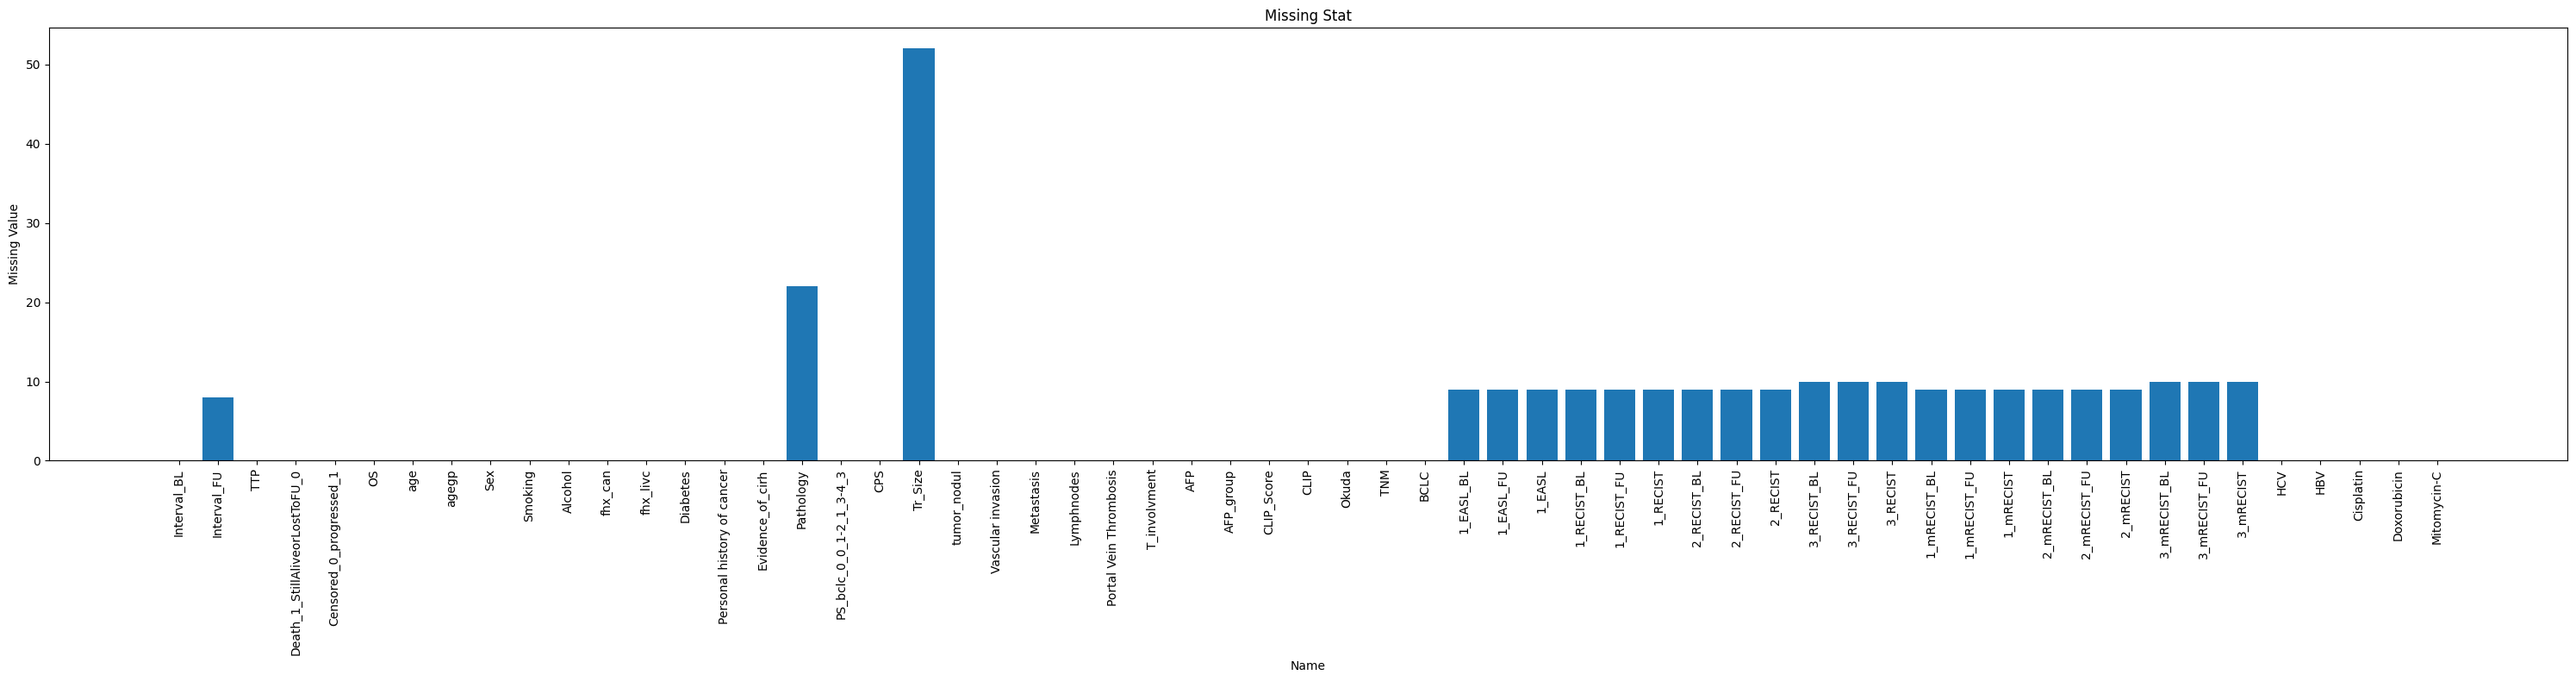

In [32]:

import copy
import os
import numpy as np
import pandas as pd
import shutil
import json

def load_data(data_path,label_name,train_list):
    data_dicts = []
    for path in train_list:
      image_path=os.path.join(data_path,path)
      split_path=path.split('/')
      patients=split_path[0]
      # print(patients)
      if patients in ['HCC_017', 'HCC_025', 'HCC_009', 'HCC_008']:
          print('排除问题数据:', path)
          continue
      # if path == 'HCC_008/103 3 PHASE LIVER (ABD) - acquisitionNumber 1.nrrd':
      #     print('排除问题数据*:', path)
      #     continue

      label_path=os.path.join(data_path,patients, label_name)

      data_dicts.append({'image': image_path, 'label': label_path})
    return data_dicts

def model_selection(file_path):

    file_list = os.listdir(file_path)
    print(file_list)
    max_dice_value = 0
    select_index = 1
    for idx, file_name in enumerate(file_list):

        if 'net_key_metric' in file_name:
            # print('ok new')
            dice_value_str = file_name.split('=')[1]
            # print(dice_value_str)
            dice_value = float(dice_value_str.split('.p')[0])
            # print(dice_value)
            if dice_value> max_dice_value:
                select_index = idx

    select_name = file_list[select_index]

    return select_name

if __name__ == '__main__':
    with open('./Train.txt', 'r') as filetrain:
        train_list = filetrain.read().split(',')

    with open('./Test.txt', 'r') as filetest:
        test_list = filetest.read().split(',')

    # base_path = '/root/autodl-tmp/dataset'
    data_path = './drive/MyDrive/HCC'
    base_path = data_path.replace('/HCC', '')
    table_save_path = os.path.join(base_path, 'support_data.csv')
    input_csv_path = os.path.join(data_path, 'HCC-TACE-Seg_clinical_data-V2.xlsx')

    input_base_path_1 = "./runs_{}_fold{}_{}/".format('08', '0', 'expr')
    os.makedirs(input_base_path_1, exist_ok=True)
    input_load_data_path = os.path.join(input_base_path_1, 'support_data.csv')
    csv_support_computer(input_csv_path, table_save_path, input_load_data_path)
    label_name = "Segmentation.seg.nrrd"
    data_monai_dataset = os.path.join(base_path, 'Dataset247_monaiData')
    os.makedirs(data_monai_dataset, exist_ok=True)
    save_dataPath_label = os.path.join(data_monai_dataset, 'labelsTr')
    os.makedirs(save_dataPath_label, exist_ok=True)
    save_dataPath_image = os.path.join(data_monai_dataset, 'imagesTr')
    os.makedirs(save_dataPath_image, exist_ok=True)
    save_dataPath_imageTs = os.path.join(data_monai_dataset, 'imagesTs')
    os.makedirs(save_dataPath_imageTs, exist_ok=True)
    save_dataPath_labelTs = os.path.join(data_monai_dataset, 'labelsTs')
    os.makedirs(save_dataPath_labelTs, exist_ok=True)
    json_save_file = os.path.join(data_monai_dataset, 'dataset.json')

    train_data_dicts = load_data(data_path, label_name, train_list)
    test_data_dicts = load_data(data_path, label_name, test_list)
    print(len(train_data_dicts), len(test_data_dicts))

    json_save_file_net = os.path.join(base_path, 'dataset_task08.json')
    dataset_json_dict = {
        "modality": {
            "0": "CT"
        },
        "labels": {
            "0": "background",
            "1": "liver",
            "2": "tumor",
            "3": "portal_vein",
            "4": "abdominal aorta"
        },
        "file_ending": ".nrrd",
        "name": "hccMonai",
        "reference": "none",
        "release": "prerelease",
        "overwrite_image_reader_writer": "SimpleITKIO"
    }


    check_dict = {}
    train_list = []
    for idx, train_dict in enumerate(train_data_dicts):

        print(idx, '')
        tag_value = train_dict['image'].split('/')[-2].split('_')[1]
        # if  tag_value == '030':
        #     print('end')
            # continue
        if tag_value in check_dict.keys():

            tag_name = str(int(tag_value) + 400 + check_dict[tag_value] * 100)
            check_dict[tag_value] += 1
            print(tag_name, tag_value)
        else:
            check_dict[tag_value] = 1
            tag_name = str(tag_value).zfill(3)

        nii_label_path = os.path.join(save_dataPath_label, 'HCC_' + tag_name  + '.nrrd')
        nii_image_path = os.path.join(save_dataPath_image, 'HCC_' + tag_name + '_0000.nrrd')

        shutil.copy2(train_dict['image'], nii_image_path)
        shutil.copy2(train_dict['label'], nii_label_path)

        train_info_dict = {'image': nii_image_path,
                           'label': nii_label_path}
        train_list.append(copy.deepcopy(train_info_dict))

    dataset_json_dict['training'] = train_list



    check_dict = {}
    val_list = []
    for idx, test_dict in enumerate(test_data_dicts):
        tag_value = test_dict['image'].split('/')[-2].split('_')[1]

        if tag_value in check_dict.keys():

            tag_name = str(int(tag_value) + 400 + check_dict[tag_value] * 100)

            check_dict[tag_value] += 1
            print(tag_name, tag_value)
        else:
            check_dict[tag_value] = 1
            tag_name = str(tag_value).zfill(3)

        nii_image_path = os.path.join(save_dataPath_imageTs, 'HCC_' + tag_name + '_0000.nrrd')
        nii_label_path = os.path.join(save_dataPath_labelTs, 'HCC_' + tag_name + '.nrrd')

        val_info_dict = {'image': nii_image_path,
                           'label': nii_label_path}
        shutil.copy2(test_dict['image'], nii_image_path)
        shutil.copy2(test_dict['label'], nii_label_path)

        val_list.append(copy.deepcopy(val_info_dict))

    with open(json_save_file, 'w') as json_file:
        json.dump(dataset_json_dict, json_file)

    dataset_json_dict['train_fold0'] = train_list
    dataset_json_dict['validation_fold0'] = val_list

    with open(json_save_file_net, 'w') as json_file:
        json.dump(dataset_json_dict, json_file)
    print('end')

    # 开始模型训练
    print_config()
    root_path = base_path
    train(root_path, max_epochs_value=1000)
    print('train end')

    # 开始模型推理
    model_save_path = "./runs_{}_fold{}_{}/".format('08', '0', 'expr')
    model_name = model_selection(model_save_path)
    print(model_name)
    inference(model_name, root_path)
    print('前往./',model_save_path, '/Dataset247_monaiData 查看结果')

